# pix2pix

**Image to image translation** is a task defined by translating a representation of an image to a representation in a different domain, while maintaining its underlying structure. The **Pix2Pix** model is a neural network designed specifically for this purpose, capable of handling any translation scenario. It is a highly flexible model equipped with an adaptable loss function suitable for various translation domains. Importantly, this framework is not limited to specific tasks and can adjust to a wide range of conditions.

Pix2Pix is a conditional Gan, which means it is a conditional generative model. It learns to represent data based on a provided input. Conditional GANs, or cGans, learn a structured loss, that permits the model to treat the output space as structured, treating each output pixel as considered conditionally dependent from all others given the input image, thus establishing the conditional nature of the model.

The pix2pix model is composed of two elements, a generator $G$ and a discriminator $D$. The generator's goal is learning to create convincing fake representations of data, while the discriminator's goal is learn to discern real from fake images.

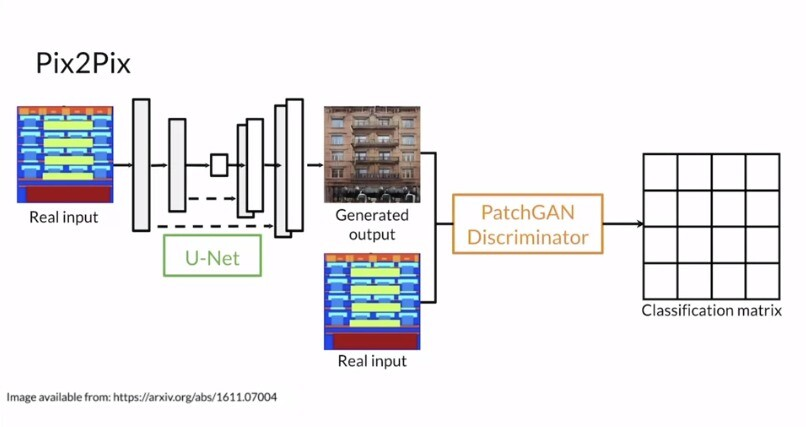

The pix2pix loss functions are defined bellow, where $x$ is the observed input image,$z$ a random noise vector and $y$ the image generated by the generator ($G(x,z) = y $).

1. **Discriminator loss**: The discrminators goal is to maximize it's capacity of distinguishing real from fake images. It's loss function penalizes it when it gets the classification wrong.

$$
\text{Loss}_{D} = -\frac{1}{2} \mathbb{E}_{x,y}[\log D(x, y)] - \frac{1}{2} \mathbb{E}_{x,z}[\log (1 - D(x, G(x, z)))]
$$
  - $\mathbb{E}_{x,y}[\log D(x, y)]$ states the discriminator should classify real images as real.
  - $\mathbb{E}_{x,z}[\log (1 - D(x, G(x, z)))]$ states the discriminator should recognize fake images created by $G$ as fake.

2. **Generator's loss (G)**: the genator's goal is to fool the discriminator, making it believe generated iamges are real. The generator loss function is defined as to penalize it when the discrminator can identify generated images as fake.Is is shown bellow:

   $$
   \text{Loss}_{\text{G}} = - \mathbb{E}_{x,z}[\log D(x, G(x, z))]
   $$

   In this case:
   - $\mathbb{E}_{x,z}[\log D(x, G(x, z))]$ measures how well $G$ can fool $D$, where $D(x, G(x, z))$ is the probability of $D$ finding $G(x,z)$ to be a real sample.
  - Finally, the authors decided to use $L1$ Loss as to diminish blurring in generated images; this decision is based on empirical studies. Thus the generators's final objective function is:

$$
G^* = \arg \min_G \max_D \mathcal{L}_{cGAN}(G, D) + \lambda \mathcal{L}_{L1}(G).
$$

Next, the implementation of the model is detailed. Code is adapted from the original paper, available on [github](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix.git).


# Code

## Datasets

### BaseDataset
This Python module provides an abstract base class (ABC) named `BaseDataset` for datasets, suitable for use in machine learning and deep learning frameworks. It includes essential transformation functions like `get_transform` and private functions such as `__scale_width`, which are intended for image preprocessing steps. The module extends the functionality of PyTorch's `data.Dataset` and mandates the implementation of key methods such as `__init__`, `__len__`, and `__getitem__` in subclasses. It also allows for dataset-specific customization of command line options, crucial for adapting to different experimental settings. These capabilities make it highly adaptable for various data handling and preprocessing needs in computational models.


In [ ]:
"""This module implements an abstract base class (ABC) 'BaseDataset' for datasets.

It also includes common transformation functions (e.g., get_transform, __scale_width), which can be later used in subclasses.
"""
import random
import numpy as np
import torch.utils.data as data
from PIL import Image
import torchvision.transforms as transforms
from abc import ABC, abstractmethod


class BaseDataset(data.Dataset, ABC):
    """This class is an abstract base class (ABC) for datasets.

    To create a subclass, you need to implement the following four functions:
    -- <__init__>:                      initialize the class, first call BaseDataset.__init__(self, opt).
    -- <__len__>:                       return the size of dataset.
    -- <__getitem__>:                   get a data point.
    -- <modify_commandline_options>:    (optionally) add dataset-specific options and set default options.
    """

    def __init__(self, opt):
        """Initialize the class; save the options in the class

        Parameters:
            opt (Option class)-- stores all the experiment flags; needs to be a subclass of BaseOptions
        """
        self.opt = opt
        self.root = opt.dataroot

    @staticmethod
    def modify_commandline_options(parser, is_train):
        """Add new dataset-specific options, and rewrite default values for existing options.

        Parameters:
            parser          -- original option parser
            is_train (bool) -- whether training phase or test phase. You can use this flag to add training-specific or test-specific options.

        Returns:
            the modified parser.
        """
        return parser

    @abstractmethod
    def __len__(self):
        """Return the total number of images in the dataset."""
        return 0

    @abstractmethod
    def __getitem__(self, index):
        """Return a data point and its metadata information.

        Parameters:
            index - - a random integer for data indexing

        Returns:
            a dictionary of data with their names. It ususally contains the data itself and its metadata information.
        """
        pass


def get_params(opt, size):
    w, h = size
    new_h = h
    new_w = w
    if opt.preprocess == 'resize_and_crop':
        new_h = new_w = opt.load_size
    elif opt.preprocess == 'scale_width_and_crop':
        new_w = opt.load_size
        new_h = opt.load_size * h // w

    x = random.randint(0, np.maximum(0, new_w - opt.crop_size))
    y = random.randint(0, np.maximum(0, new_h - opt.crop_size))

    flip = random.random() > 0.5

    return {'crop_pos': (x, y), 'flip': flip}


def get_transform(opt, params=None, grayscale=False, method=transforms.InterpolationMode.BICUBIC, convert=True):
    transform_list = []
    if grayscale:
        transform_list.append(transforms.Grayscale(1))
    if 'resize' in opt.preprocess:
        osize = [opt.load_size, opt.load_size]
        transform_list.append(transforms.Resize(osize, method))
    elif 'scale_width' in opt.preprocess:
        transform_list.append(transforms.Lambda(lambda img: __scale_width(img, opt.load_size, opt.crop_size, method)))

    if 'crop' in opt.preprocess:
        if params is None:
            transform_list.append(transforms.RandomCrop(opt.crop_size))
        else:
            transform_list.append(transforms.Lambda(lambda img: __crop(img, params['crop_pos'], opt.crop_size)))

    if opt.preprocess == 'none':
        transform_list.append(transforms.Lambda(lambda img: __make_power_2(img, base=4, method=method)))

    if not opt.no_flip:
        if params is None:
            transform_list.append(transforms.RandomHorizontalFlip())
        elif params['flip']:
            transform_list.append(transforms.Lambda(lambda img: __flip(img, params['flip'])))

    if convert:
        transform_list += [transforms.ToTensor()]
        if grayscale:
            transform_list += [transforms.Normalize((0.5,), (0.5,))]
        else:
            transform_list += [transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    return transforms.Compose(transform_list)


def __transforms2pil_resize(method):
    mapper = {transforms.InterpolationMode.BILINEAR: Image.BILINEAR,
              transforms.InterpolationMode.BICUBIC: Image.BICUBIC,
              transforms.InterpolationMode.NEAREST: Image.NEAREST,
              transforms.InterpolationMode.LANCZOS: Image.LANCZOS,}
    return mapper[method]


def __make_power_2(img, base, method=transforms.InterpolationMode.BICUBIC):
    method = __transforms2pil_resize(method)
    ow, oh = img.size
    h = int(round(oh / base) * base)
    w = int(round(ow / base) * base)
    if h == oh and w == ow:
        return img

    __print_size_warning(ow, oh, w, h)
    return img.resize((w, h), method)


def __scale_width(img, target_size, crop_size, method=transforms.InterpolationMode.BICUBIC):
    method = __transforms2pil_resize(method)
    ow, oh = img.size
    if ow == target_size and oh >= crop_size:
        return img
    w = target_size
    h = int(max(target_size * oh / ow, crop_size))
    return img.resize((w, h), method)


def __crop(img, pos, size):
    ow, oh = img.size
    x1, y1 = pos
    tw = th = size
    if (ow > tw or oh > th):
        return img.crop((x1, y1, x1 + tw, y1 + th))
    return img


def __flip(img, flip):
    if flip:
        return img.transpose(Image.FLIP_LEFT_RIGHT)
    return img


def __print_size_warning(ow, oh, w, h):
    """Print warning information about image size(only print once)"""
    if not hasattr(__print_size_warning, 'has_printed'):
        print("The image size needs to be a multiple of 4. "
              "The loaded image size was (%d, %d), so it was adjusted to "
              "(%d, %d). This adjustment will be done to all images "
              "whose sizes are not multiples of 4" % (ow, oh, w, h))
        __print_size_warning.has_printed = True


### AlignedDataset
 Defines a class for handling paired image datasets typically used in image-to-image translation tasks. It initializes datasets based on user-defined options, shuffles the data for randomness, and selectively loads training or testing data. The images are assumed to be stored in specific directory structures, and each image pair contains corresponding images from two different domains ($A$ and $B$). During data loading, images are split, transformed, and returned as input and target domain pairs. The class provides methods to retrieve individual data points and the total number of images in the dataset.

In [ ]:
import os
import random

random.seed(26)

class AlignedDataset(BaseDataset):
    """A dataset class for paired image dataset.

    It assumes that the directory '/path/to/data/train' contains image pairs in the form of {A,B}.
    During test time, you need to prepare a directory '/path/to/data/test'.
    """

    def __init__(self, opt):
        """Initialize this dataset class.

        Parameters:
            opt (Option class) -- stores all the experiment flags; needs to be a subclass of BaseOptions
        """
        BaseDataset.__init__(self, opt)
        self.dir_AB = os.path.join(opt.dataroot, opt.phase)  # get the image directory
        files = os.listdir(self.dir_AB)
        AB_paths = sorted(os.path.join(self.dir_AB, file) for file in files)  # get image paths
        random.shuffle(AB_paths)
        if (opt.isTrain):
            self.AB_paths = AB_paths[0:3193]
        else:
            self.AB_paths = AB_paths[3194:]
        assert(self.opt.load_size >= self.opt.crop_size)   # crop_size should be smaller than the size of loaded image
        self.input_nc = self.opt.output_nc if self.opt.direction == 'BtoA' else self.opt.input_nc
        self.output_nc = self.opt.input_nc if self.opt.direction == 'BtoA' else self.opt.output_nc

    def __getitem__(self, index):
        """Return a data point and its metadata information.

        Parameters:
            index - - a random integer for data indexing

        Returns a dictionary that contains A, B, A_paths and B_paths
            A (tensor) - - an image in the input domain
            B (tensor) - - its corresponding image in the target domain
            A_paths (str) - - image paths
            B_paths (str) - - image paths (same as A_paths)
        """
        # read a image given a random integer index
        AB_path = self.AB_paths[index]
        AB = Image.open(AB_path).convert('RGB')
        # split AB image into A and B
        w, h = AB.size
        w2 = int(w / 2)
        A = AB.crop((0, 0, w2, h))
        B = AB.crop((w2, 0, w, h))

        # apply the same transform to both A and B
        transform_params = get_params(self.opt, A.size)
        A_transform = get_transform(self.opt, transform_params, grayscale=(self.input_nc == 1))
        B_transform = get_transform(self.opt, transform_params, grayscale=(self.output_nc == 1))

        A = A_transform(A)
        B = B_transform(B)

        return {'A': A, 'B': B, 'A_paths': AB_path, 'B_paths': AB_path}

    def __len__(self):
        """Return the total number of images in the dataset."""
        return len(self.AB_paths)

## Networks

**Network Architecture**

For the generator, a U-Net-based architecture equipped with skip connections is utilized. The implementation of skip connections ensures that the structure in the input is closely aligned with the structure in the output, thereby preserving essential low-level information throughout the network. This feature is crucial for maintaining the integrity and detail of the input data as it progresses through the model.

In contrast, the discriminator employs a Markovian convolutional "PatchGAN" classifier, which focuses on penalizing structures at the scale of image patches rather than the entire image. This approach involves classifying whether each NxN patch within an image is real or fake. The classifier operates convolutionally across the image, aggregating responses to produce the final output from the discriminator.


#### Helper functions and classes
This section defines helper functions and network classes in the conditional GAN. Functions include network weight initialization, normalization layer selection, learning rate scheduler configuration, and the creation of generators and discriminators with various architectures. The code also implements network initialization and configuration for running on specific devices, such as GPUs.

In [ ]:
import torch
import torch.nn as nn
from torch.nn import init
import functools
from torch.optim import lr_scheduler


###############################################################################
# Helper Functions
###############################################################################


class Identity(nn.Module):
    def forward(self, x):
        return x


def get_norm_layer(norm_type='instance'):
    """Return a normalization layer

    Parameters:
        norm_type (str) -- the name of the normalization layer: batch | instance | none

    For BatchNorm, we use learnable affine parameters and track running statistics (mean/stddev).
    For InstanceNorm, we do not use learnable affine parameters. We do not track running statistics.
    """
    if norm_type == 'batch':
        norm_layer = functools.partial(nn.BatchNorm2d, affine=True, track_running_stats=True)
    elif norm_type == 'instance':
        norm_layer = functools.partial(nn.InstanceNorm2d, affine=False, track_running_stats=False)
    elif norm_type == 'none':
        def norm_layer(x):
            return Identity()
    else:
        raise NotImplementedError('normalization layer [%s] is not found' % norm_type)
    return norm_layer


def get_scheduler(optimizer, opt):
    """Return a learning rate scheduler

    Parameters:
        optimizer          -- the optimizer of the network
        opt (option class) -- stores all the experiment flags; needs to be a subclass of BaseOptions．
                              opt.lr_policy is the name of learning rate policy: linear | step | plateau | cosine

    For 'linear', we keep the same learning rate for the first <opt.n_epochs> epochs
    and linearly decay the rate to zero over the next <opt.n_epochs_decay> epochs.
    For other schedulers (step, plateau, and cosine), we use the default PyTorch schedulers.
    See https://pytorch.org/docs/stable/optim.html for more details.
    """
    if opt.lr_policy == 'linear':
        def lambda_rule(epoch):
            lr_l = 1.0 - max(0, epoch + opt.epoch_count - opt.n_epochs) / float(opt.n_epochs_decay + 1)
            return lr_l
        scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_rule)
    elif opt.lr_policy == 'step':
        scheduler = lr_scheduler.StepLR(optimizer, step_size=opt.lr_decay_iters, gamma=0.1)
    elif opt.lr_policy == 'plateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, threshold=0.01, patience=5)
    elif opt.lr_policy == 'cosine':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=opt.n_epochs, eta_min=0)
    else:
        return NotImplementedError('learning rate policy [%s] is not implemented', opt.lr_policy)
    return scheduler


def init_weights(net, init_type='normal', init_gain=0.02):
    """Initialize network weights.

    Parameters:
        net (network)   -- network to be initialized
        init_type (str) -- the name of an initialization method: normal | xavier | kaiming | orthogonal
        init_gain (float)    -- scaling factor for normal, xavier and orthogonal.

    We use 'normal' in the original pix2pix and CycleGAN paper. But xavier and kaiming might
    work better for some applications. Feel free to try yourself.
    """
    def init_func(m):  # define the initialization function
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, init_gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=init_gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=init_gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
            init.normal_(m.weight.data, 1.0, init_gain)
            init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)  # apply the initialization function <init_func>


def init_net(net, init_type='normal', init_gain=0.02, gpu_ids=[]):
    """Initialize a network: 1. register CPU/GPU device (with multi-GPU support); 2. initialize the network weights
    Parameters:
        net (network)      -- the network to be initialized
        init_type (str)    -- the name of an initialization method: normal | xavier | kaiming | orthogonal
        gain (float)       -- scaling factor for normal, xavier and orthogonal.
        gpu_ids (int list) -- which GPUs the network runs on: e.g., 0,1,2

    Return an initialized network.
    """
    if len(gpu_ids) > 0:
        assert(torch.cuda.is_available())
        net.to(gpu_ids[0])
        net = torch.nn.DataParallel(net, gpu_ids)  # multi-GPUs
    init_weights(net, init_type, init_gain=init_gain)
    return net


def define_G(input_nc, output_nc, ngf, netG, norm='batch', use_dropout=False, init_type='normal', init_gain=0.02, gpu_ids=[]):
    """Create a generator

    Parameters:
        input_nc (int) -- the number of channels in input images
        output_nc (int) -- the number of channels in output images
        ngf (int) -- the number of filters in the last conv layer
        netG (str) -- the architecture's name: resnet_9blocks | resnet_6blocks | unet_256 | unet_128
        norm (str) -- the name of normalization layers used in the network: batch | instance | none
        use_dropout (bool) -- if use dropout layers.
        init_type (str)    -- the name of our initialization method.
        init_gain (float)  -- scaling factor for normal, xavier and orthogonal.
        gpu_ids (int list) -- which GPUs the network runs on: e.g., 0,1,2

    Returns a generator

    Our current implementation provides two types of generators:
        U-Net: [unet_128] (for 128x128 input images) and [unet_256] (for 256x256 input images)
        The original U-Net paper: https://arxiv.org/abs/1505.04597

        Resnet-based generator: [resnet_6blocks] (with 6 Resnet blocks) and [resnet_9blocks] (with 9 Resnet blocks)
        Resnet-based generator consists of several Resnet blocks between a few downsampling/upsampling operations.
        We adapt Torch code from Justin Johnson's neural style transfer project (https://github.com/jcjohnson/fast-neural-style).


    The generator has been initialized by <init_net>. It uses RELU for non-linearity.
    """
    net = None
    norm_layer = get_norm_layer(norm_type=norm)

    if netG == 'resnet_9blocks':
        net = ResnetGenerator(input_nc, output_nc, ngf, norm_layer=norm_layer, use_dropout=use_dropout, n_blocks=9)
    elif netG == 'resnet_6blocks':
        net = ResnetGenerator(input_nc, output_nc, ngf, norm_layer=norm_layer, use_dropout=use_dropout, n_blocks=6)
    elif netG == 'unet_128':
        net = UnetGenerator(input_nc, output_nc, 7, ngf, norm_layer=norm_layer, use_dropout=use_dropout)
    elif netG == 'unet_256':
        net = UnetGenerator(input_nc, output_nc, 8, ngf, norm_layer=norm_layer, use_dropout=use_dropout)
    else:
        raise NotImplementedError('Generator model name [%s] is not recognized' % netG)
    return init_net(net, init_type, init_gain, gpu_ids)


def define_D(input_nc, ndf, netD, n_layers_D=3, norm='batch', init_type='normal', init_gain=0.02, gpu_ids=[]):
    """Create a discriminator

    Parameters:
        input_nc (int)     -- the number of channels in input images
        ndf (int)          -- the number of filters in the first conv layer
        netD (str)         -- the architecture's name: basic | n_layers | pixel
        n_layers_D (int)   -- the number of conv layers in the discriminator; effective when netD=='n_layers'
        norm (str)         -- the type of normalization layers used in the network.
        init_type (str)    -- the name of the initialization method.
        init_gain (float)  -- scaling factor for normal, xavier and orthogonal.
        gpu_ids (int list) -- which GPUs the network runs on: e.g., 0,1,2

    Returns a discriminator

    Our current implementation provides three types of discriminators:
        [basic]: 'PatchGAN' classifier described in the original pix2pix paper.
        It can classify whether 70×70 overlapping patches are real or fake.
        Such a patch-level discriminator architecture has fewer parameters
        than a full-image discriminator and can work on arbitrarily-sized images
        in a fully convolutional fashion.

        [n_layers]: With this mode, you can specify the number of conv layers in the discriminator
        with the parameter <n_layers_D> (default=3 as used in [basic] (PatchGAN).)

        [pixel]: 1x1 PixelGAN discriminator can classify whether a pixel is real or not.
        It encourages greater color diversity but has no effect on spatial statistics.

    The discriminator has been initialized by <init_net>. It uses Leakly RELU for non-linearity.
    """
    net = None
    norm_layer = get_norm_layer(norm_type=norm)

    if netD == 'basic':  # default PatchGAN classifier
        net = NLayerDiscriminator(input_nc, ndf, n_layers=3, norm_layer=norm_layer)
    elif netD == 'n_layers':  # more options
        net = NLayerDiscriminator(input_nc, ndf, n_layers_D, norm_layer=norm_layer)
    elif netD == 'pixel':     # classify if each pixel is real or fake
        net = PixelDiscriminator(input_nc, ndf, norm_layer=norm_layer)
    else:
        raise NotImplementedError('Discriminator model name [%s] is not recognized' % netD)
    return init_net(net, init_type, init_gain, gpu_ids)


##############################################################################
# Classes
##############################################################################
class GANLoss(nn.Module):
    """Define different GAN objectives.

    The GANLoss class abstracts away the need to create the target label tensor
    that has the same size as the input.
    """

    def __init__(self, gan_mode, target_real_label=1.0, target_fake_label=0.0):
        """ Initialize the GANLoss class.

        Parameters:
            gan_mode (str) - - the type of GAN objective. It currently supports vanilla, lsgan, and wgangp.
            target_real_label (bool) - - label for a real image
            target_fake_label (bool) - - label of a fake image

        Note: Do not use sigmoid as the last layer of Discriminator.
        LSGAN needs no sigmoid. vanilla GANs will handle it with BCEWithLogitsLoss.
        """
        super(GANLoss, self).__init__()
        self.register_buffer('real_label', torch.tensor(target_real_label))
        self.register_buffer('fake_label', torch.tensor(target_fake_label))
        self.gan_mode = gan_mode
        if gan_mode == 'lsgan':
            self.loss = nn.MSELoss()
        elif gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode in ['wgangp']:
            self.loss = None
        else:
            raise NotImplementedError('gan mode %s not implemented' % gan_mode)

    def get_target_tensor(self, prediction, target_is_real):
        """Create label tensors with the same size as the input.

        Parameters:
            prediction (tensor) - - tpyically the prediction from a discriminator
            target_is_real (bool) - - if the ground truth label is for real images or fake images

        Returns:
            A label tensor filled with ground truth label, and with the size of the input
        """

        if target_is_real:
            target_tensor = self.real_label
        else:
            target_tensor = self.fake_label
        return target_tensor.expand_as(prediction)

    def __call__(self, prediction, target_is_real):
        """Calculate loss given Discriminator's output and grount truth labels.

        Parameters:
            prediction (tensor) - - tpyically the prediction output from a discriminator
            target_is_real (bool) - - if the ground truth label is for real images or fake images

        Returns:
            the calculated loss.
        """
        if self.gan_mode in ['lsgan', 'vanilla']:
            target_tensor = self.get_target_tensor(prediction, target_is_real)
            loss = self.loss(prediction, target_tensor)
        elif self.gan_mode == 'wgangp':
            if target_is_real:
                loss = -prediction.mean()
            else:
                loss = prediction.mean()
        return loss


def cal_gradient_penalty(netD, real_data, fake_data, device, type='mixed', constant=1.0, lambda_gp=10.0):
    """Calculate the gradient penalty loss, used in WGAN-GP paper https://arxiv.org/abs/1704.00028

    Arguments:
        netD (network)              -- discriminator network
        real_data (tensor array)    -- real images
        fake_data (tensor array)    -- generated images from the generator
        device (str)                -- GPU / CPU: from torch.device('cuda:{}'.format(self.gpu_ids[0])) if self.gpu_ids else torch.device('cpu')
        type (str)                  -- if we mix real and fake data or not [real | fake | mixed].
        constant (float)            -- the constant used in formula ( ||gradient||_2 - constant)^2
        lambda_gp (float)           -- weight for this loss

    Returns the gradient penalty loss
    """
    if lambda_gp > 0.0:
        if type == 'real':   # either use real images, fake images, or a linear interpolation of two.
            interpolatesv = real_data
        elif type == 'fake':
            interpolatesv = fake_data
        elif type == 'mixed':
            alpha = torch.rand(real_data.shape[0], 1, device=device)
            alpha = alpha.expand(real_data.shape[0], real_data.nelement() // real_data.shape[0]).contiguous().view(*real_data.shape)
            interpolatesv = alpha * real_data + ((1 - alpha) * fake_data)
        else:
            raise NotImplementedError('{} not implemented'.format(type))
        interpolatesv.requires_grad_(True)
        disc_interpolates = netD(interpolatesv)
        gradients = torch.autograd.grad(outputs=disc_interpolates, inputs=interpolatesv,
                                        grad_outputs=torch.ones(disc_interpolates.size()).to(device),
                                        create_graph=True, retain_graph=True, only_inputs=True)
        gradients = gradients[0].view(real_data.size(0), -1)  # flat the data
        gradient_penalty = (((gradients + 1e-16).norm(2, dim=1) - constant) ** 2).mean() * lambda_gp        # added eps
        return gradient_penalty, gradients
    else:
        return 0.0, None


class ResnetGenerator(nn.Module):
    """Resnet-based generator that consists of Resnet blocks between a few downsampling/upsampling operations.

    We adapt Torch code and idea from Justin Johnson's neural style transfer project(https://github.com/jcjohnson/fast-neural-style)
    """

    def __init__(self, input_nc, output_nc, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False, n_blocks=6, padding_type='reflect'):
        """Construct a Resnet-based generator

        Parameters:
            input_nc (int)      -- the number of channels in input images
            output_nc (int)     -- the number of channels in output images
            ngf (int)           -- the number of filters in the last conv layer
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers
            n_blocks (int)      -- the number of ResNet blocks
            padding_type (str)  -- the name of padding layer in conv layers: reflect | replicate | zero
        """
        assert(n_blocks >= 0)
        super(ResnetGenerator, self).__init__()
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=use_bias),
                 norm_layer(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):  # add downsampling layers
            mult = 2 ** i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1, bias=use_bias),
                      norm_layer(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2 ** n_downsampling
        for i in range(n_blocks):       # add ResNet blocks

            model += [ResnetBlock(ngf * mult, padding_type=padding_type, norm_layer=norm_layer, use_dropout=use_dropout, use_bias=use_bias)]

        for i in range(n_downsampling):  # add upsampling layers
            mult = 2 ** (n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=use_bias),
                      norm_layer(int(ngf * mult / 2)),
                      nn.ReLU(True)]
        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input):
        """Standard forward"""
        return self.model(input)


class ResnetBlock(nn.Module):
    """Define a Resnet block"""

    def __init__(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        """Initialize the Resnet block

        A resnet block is a conv block with skip connections
        We construct a conv block with build_conv_block function,
        and implement skip connections in <forward> function.
        Original Resnet paper: https://arxiv.org/pdf/1512.03385.pdf
        """
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, use_bias)

    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        """Construct a convolutional block.

        Parameters:
            dim (int)           -- the number of channels in the conv layer.
            padding_type (str)  -- the name of padding layer: reflect | replicate | zero
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
            use_bias (bool)     -- if the conv layer uses bias or not

        Returns a conv block (with a conv layer, a normalization layer, and a non-linearity layer (ReLU))
        """
        conv_block = []
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim), nn.ReLU(True)]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        """Forward function (with skip connections)"""
        out = x + self.conv_block(x)  # add skip connections
        return out


class UnetGenerator(nn.Module):
    """Create a Unet-based generator"""

    def __init__(self, input_nc, output_nc, num_downs, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False):
        """Construct a Unet generator
        Parameters:
            input_nc (int)  -- the number of channels in input images
            output_nc (int) -- the number of channels in output images
            num_downs (int) -- the number of downsamplings in UNet. For example, # if |num_downs| == 7,
                                image of size 128x128 will become of size 1x1 # at the bottleneck
            ngf (int)       -- the number of filters in the last conv layer
            norm_layer      -- normalization layer

        We construct the U-Net from the innermost layer to the outermost layer.
        It is a recursive process.
        """
        super(UnetGenerator, self).__init__()
        # construct unet structure
        unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=None, norm_layer=norm_layer, innermost=True)  # add the innermost layer
        for i in range(num_downs - 5):          # add intermediate layers with ngf * 8 filters
            unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer, use_dropout=use_dropout)
        # gradually reduce the number of filters from ngf * 8 to ngf
        unet_block = UnetSkipConnectionBlock(ngf * 4, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf * 2, ngf * 4, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf, ngf * 2, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        self.model = UnetSkipConnectionBlock(output_nc, ngf, input_nc=input_nc, submodule=unet_block, outermost=True, norm_layer=norm_layer)  # add the outermost layer

    def forward(self, input):
        """Standard forward"""
        return self.model(input)


class UnetSkipConnectionBlock(nn.Module):
    """Defines the Unet submodule with skip connection.
        X -------------------identity----------------------
        |-- downsampling -- |submodule| -- upsampling --|
    """

    def __init__(self, outer_nc, inner_nc, input_nc=None,
                 submodule=None, outermost=False, innermost=False, norm_layer=nn.BatchNorm2d, use_dropout=False):
        """Construct a Unet submodule with skip connections.

        Parameters:
            outer_nc (int) -- the number of filters in the outer conv layer
            inner_nc (int) -- the number of filters in the inner conv layer
            input_nc (int) -- the number of channels in input images/features
            submodule (UnetSkipConnectionBlock) -- previously defined submodules
            outermost (bool)    -- if this module is the outermost module
            innermost (bool)    -- if this module is the innermost module
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
        """
        super(UnetSkipConnectionBlock, self).__init__()
        self.outermost = outermost
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d
        if input_nc is None:
            input_nc = outer_nc
        downconv = nn.Conv2d(input_nc, inner_nc, kernel_size=4,
                             stride=2, padding=1, bias=use_bias)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = norm_layer(inner_nc)
        uprelu = nn.ReLU(True)
        upnorm = norm_layer(outer_nc)

        if outermost:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(inner_nc, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]

            if use_dropout:
                model = down + [submodule] + up + [nn.Dropout(0.5)]
            else:
                model = down + [submodule] + up

        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:   # add skip connections
            return torch.cat([x, self.model(x)], 1)


class NLayerDiscriminator(nn.Module):
    """Defines a PatchGAN discriminator"""

    def __init__(self, input_nc, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d):
        """Construct a PatchGAN discriminator

        Parameters:
            input_nc (int)  -- the number of channels in input images
            ndf (int)       -- the number of filters in the last conv layer
            n_layers (int)  -- the number of conv layers in the discriminator
            norm_layer      -- normalization layer
        """
        super(NLayerDiscriminator, self).__init__()
        if type(norm_layer) == functools.partial:  # no need to use bias as BatchNorm2d has affine parameters
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        kw = 4
        padw = 1
        sequence = [nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw), nn.LeakyReLU(0.2, True)]
        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):  # gradually increase the number of filters
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=2, padding=padw, bias=use_bias),
                norm_layer(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=1, padding=padw, bias=use_bias),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]  # output 1 channel prediction map
        self.model = nn.Sequential(*sequence)

    def forward(self, input):
        """Standard forward."""
        return self.model(input)


class PixelDiscriminator(nn.Module):
    """Defines a 1x1 PatchGAN discriminator (pixelGAN)"""

    def __init__(self, input_nc, ndf=64, norm_layer=nn.BatchNorm2d):
        """Construct a 1x1 PatchGAN discriminator

        Parameters:
            input_nc (int)  -- the number of channels in input images
            ndf (int)       -- the number of filters in the last conv layer
            norm_layer      -- normalization layer
        """
        super(PixelDiscriminator, self).__init__()
        if type(norm_layer) == functools.partial:  # no need to use bias as BatchNorm2d has affine parameters
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        self.net = [
            nn.Conv2d(input_nc, ndf, kernel_size=1, stride=1, padding=0),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf, ndf * 2, kernel_size=1, stride=1, padding=0, bias=use_bias),
            norm_layer(ndf * 2),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf * 2, 1, kernel_size=1, stride=1, padding=0, bias=use_bias)]

        self.net = nn.Sequential(*self.net)

    def forward(self, input):
        """Standard forward."""
        return self.net(input)


#### BaseModel
This section defines `BaseModel`, an abstract base class for PyTorch models. It requires subclasses to implement essential lifecycle methods such as initialization, data preprocessing, the forward pass, and optimization. The class supports model configuration, environment setup for both CPU and GPU, and provides utilities for network management including loading, saving, and updating parameters. This setup is designed to facilitate the development and management of robust machine learning models across various training and testing scenarios.


In [ ]:
import os
import torch
from collections import OrderedDict
from abc import ABC, abstractmethod


class BaseModel(ABC):
    """This class is an abstract base class (ABC) for models.
    To create a subclass, you need to implement the following five functions:
        -- <__init__>:                      initialize the class; first call BaseModel.__init__(self, opt).
        -- <set_input>:                     unpack data from dataset and apply preprocessing.
        -- <forward>:                       produce intermediate results.
        -- <optimize_parameters>:           calculate losses, gradients, and update network weights.
        -- <modify_commandline_options>:    (optionally) add model-specific options and set default options.
    """

    def __init__(self, opt):
        """Initialize the BaseModel class.

        Parameters:
            opt (Option class)-- stores all the experiment flags; needs to be a subclass of BaseOptions

        When creating your custom class, you need to implement your own initialization.
        In this function, you should first call <BaseModel.__init__(self, opt)>
        Then, you need to define four lists:
            -- self.loss_names (str list):          specify the training losses that you want to plot and save.
            -- self.model_names (str list):         define networks used in our training.
            -- self.visual_names (str list):        specify the images that you want to display and save.
            -- self.optimizers (optimizer list):    define and initialize optimizers. You can define one optimizer for each network. If two networks are updated at the same time, you can use itertools.chain to group them. See cycle_gan_model.py for an example.
        """
        self.opt = opt
        self.gpu_ids = opt.gpu_ids
        self.isTrain = opt.isTrain
        self.device = torch.device('cuda:{}'.format(self.gpu_ids[0])) if self.gpu_ids else torch.device('cpu')  # get device name: CPU or GPU
        self.save_dir = os.path.join(opt.checkpoints_dir, opt.name)  # save all the checkpoints to save_dir
        if opt.preprocess != 'scale_width':  # with [scale_width], input images might have different sizes, which hurts the performance of cudnn.benchmark.
            torch.backends.cudnn.benchmark = True
        self.loss_names = []
        self.model_names = []
        self.visual_names = []
        self.optimizers = []
        self.image_paths = []
        self.metric = 0  # used for learning rate policy 'plateau'

    @staticmethod
    def modify_commandline_options(parser, is_train):
        """Add new model-specific options, and rewrite default values for existing options.

        Parameters:
            parser          -- original option parser
            is_train (bool) -- whether training phase or test phase. You can use this flag to add training-specific or test-specific options.

        Returns:
            the modified parser.
        """
        return parser

    @abstractmethod
    def set_input(self, input):
        """Unpack input data from the dataloader and perform necessary pre-processing steps.

        Parameters:
            input (dict): includes the data itself and its metadata information.
        """
        pass

    @abstractmethod
    def forward(self):
        """Run forward pass; called by both functions <optimize_parameters> and <test>."""
        pass

    @abstractmethod
    def optimize_parameters(self):
        """Calculate losses, gradients, and update network weights; called in every training iteration"""
        pass

    def setup(self, opt):
        """Load and print networks; create schedulers

        Parameters:
            opt (Option class) -- stores all the experiment flags; needs to be a subclass of BaseOptions
        """
        if self.isTrain:
            self.schedulers = [get_scheduler(optimizer, opt) for optimizer in self.optimizers]
        if not self.isTrain or opt.continue_train:
            load_suffix = 'iter_%d' % opt.load_iter if opt.load_iter > 0 else opt.epoch
            self.load_networks(load_suffix)
        self.print_networks(opt.verbose)

    def eval(self):
        """Make models eval mode during test time"""
        for name in self.model_names:
            if isinstance(name, str):
                net = getattr(self, 'net' + name)
                net.eval()

    def test(self):
        """Forward function used in test time.

        This function wraps <forward> function in no_grad() so we don't save intermediate steps for backprop
        It also calls <compute_visuals> to produce additional visualization results
        """
        with torch.no_grad():
            self.forward()
            self.compute_visuals()

    def compute_visuals(self):
        """Calculate additional output images for visdom and HTML visualization"""
        pass

    def get_image_paths(self):
        """ Return image paths that are used to load current data"""
        return self.image_paths

    def update_learning_rate(self):
        """Update learning rates for all the networks; called at the end of every epoch"""
        old_lr = self.optimizers[0].param_groups[0]['lr']
        for scheduler in self.schedulers:
            if self.opt.lr_policy == 'plateau':
                scheduler.step(self.metric)
            else:
                scheduler.step()

        lr = self.optimizers[0].param_groups[0]['lr']
        print('learning rate %.7f -> %.7f' % (old_lr, lr))

    def get_current_visuals(self):
        """Return visualization images. train.py will display these images with visdom, and save the images to a HTML"""
        visual_ret = OrderedDict()
        for name in self.visual_names:
            if isinstance(name, str):
                visual_ret[name] = getattr(self, name)
        return visual_ret

    def get_current_losses(self):
        """Return traning losses / errors. train.py will print out these errors on console, and save them to a file"""
        errors_ret = OrderedDict()
        for name in self.loss_names:
            if isinstance(name, str):
                errors_ret[name] = float(getattr(self, 'loss_' + name))  # float(...) works for both scalar tensor and float number
        return errors_ret

    def save_networks(self, epoch):
        """Save all the networks to the disk.

        Parameters:
            epoch (int) -- current epoch; used in the file name '%s_net_%s.pth' % (epoch, name)
        """
        for name in self.model_names:
            if isinstance(name, str):
                save_filename = '%s_net_%s.pth' % (epoch, name)
                save_path = os.path.join(self.save_dir, save_filename)
                net = getattr(self, 'net' + name)

                if len(self.gpu_ids) > 0 and torch.cuda.is_available():
                    torch.save(net.module.cpu().state_dict(), save_path)
                    net.cuda(self.gpu_ids[0])
                else:
                    torch.save(net.cpu().state_dict(), save_path)

    def __patch_instance_norm_state_dict(self, state_dict, module, keys, i=0):
        """Fix InstanceNorm checkpoints incompatibility (prior to 0.4)"""
        key = keys[i]
        if i + 1 == len(keys):  # at the end, pointing to a parameter/buffer
            if module.__class__.__name__.startswith('InstanceNorm') and \
                    (key == 'running_mean' or key == 'running_var'):
                if getattr(module, key) is None:
                    state_dict.pop('.'.join(keys))
            if module.__class__.__name__.startswith('InstanceNorm') and \
               (key == 'num_batches_tracked'):
                state_dict.pop('.'.join(keys))
        else:
            self.__patch_instance_norm_state_dict(state_dict, getattr(module, key), keys, i + 1)

    def load_networks(self, epoch):
        """Load all the networks from the disk.

        Parameters:
            epoch (int) -- current epoch; used in the file name '%s_net_%s.pth' % (epoch, name)
        """
        for name in self.model_names:
            print(f'the name is: {name}')
            if isinstance(name, str):
                load_filename = '%s_net_%s.pth' % (epoch, name)
                load_path = os.path.join(self.save_dir, load_filename)
                net = getattr(self, 'net' + name)
                if isinstance(net, torch.nn.DataParallel):
                    net = net.module
                print('loading the model from %s' % load_path)
                # if you are using PyTorch newer than 0.4 (e.g., built from
                # GitHub source), you can remove str() on self.device
                state_dict = torch.load(load_path, map_location=str(self.device))
                if hasattr(state_dict, '_metadata'):
                    del state_dict._metadata

                # patch InstanceNorm checkpoints prior to 0.4
                for key in list(state_dict.keys()):  # need to copy keys here because we mutate in loop
                    self.__patch_instance_norm_state_dict(state_dict, net, key.split('.'))
                net.load_state_dict(state_dict)

    def print_networks(self, verbose):
        """Print the total number of parameters in the network and (if verbose) network architecture

        Parameters:
            verbose (bool) -- if verbose: print the network architecture
        """
        print('---------- Networks initialized -------------')
        for name in self.model_names:
            if isinstance(name, str):
                net = getattr(self, 'net' + name)
                num_params = 0
                for param in net.parameters():
                    num_params += param.numel()
                if verbose:
                    print(net)
                print('[Network %s] Total number of parameters : %.3f M' % (name, num_params / 1e6))
        print('-----------------------------------------------')

    def set_requires_grad(self, nets, requires_grad=False):
        """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
        Parameters:
            nets (network list)   -- a list of networks
            requires_grad (bool)  -- whether the networks require gradients or not
        """
        if not isinstance(nets, list):
            nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad


#### Pix2Pix
Here `Pix2PixModel`  is defined. The architecture and loss parameters can be customized, facilitating flexibility in experiments. Key operations within the model include data preprocessing, forward pass computation, and alternating optimization of the generator and discriminator using the Adam optimizer. This setup is particularly optimized for the `AlignedDataset` type where each input image directly corresponds to an output image, ensuring that the model trains under conditions that closely mimic the target application scenarios.


In [ ]:
import torch

class Pix2PixModel(BaseModel):
    """ This class implements the pix2pix model, for learning a mapping from input images to output images given paired data.

    The model training requires '--dataset_mode aligned' dataset.
    By default, it uses a '--netG unet256' U-Net generator,
    a '--netD basic' discriminator (PatchGAN),
    and a '--gan_mode' vanilla GAN loss (the cross-entropy objective used in the orignal GAN paper).

    pix2pix paper: https://arxiv.org/pdf/1611.07004.pdf
    """
    @staticmethod
    def modify_commandline_options(parser, is_train=True):
        """Add new dataset-specific options, and rewrite default values for existing options.

        Parameters:
            parser          -- original option parser
            is_train (bool) -- whether training phase or test phase. You can use this flag to add training-specific or test-specific options.

        Returns:
            the modified parser.

        For pix2pix, we do not use image buffer
        The training objective is: GAN Loss + lambda_L1 * ||G(A)-B||_1
        By default, we use vanilla GAN loss, UNet with batchnorm, and aligned datasets.
        """
        # changing the default values to match the pix2pix paper (https://phillipi.github.io/pix2pix/)
        parser.set_defaults(norm='batch', netG='unet_256', dataset_mode='aligned')
        if is_train:
            parser.set_defaults(pool_size=0, gan_mode='vanilla')
            parser.add_argument('--lambda_L1', type=float, default=100.0, help='weight for L1 loss')

        return parser

    def __init__(self, opt):
        """Initialize the pix2pix class.

        Parameters:
            opt (Option class)-- stores all the experiment flags; needs to be a subclass of BaseOptions
        """
        BaseModel.__init__(self, opt)
        # specify the training losses you want to print out. The training/test scripts will call <BaseModel.get_current_losses>
        self.loss_names = ['G_GAN', 'G_L1', 'D_real', 'D_fake']
        # specify the images you want to save/display. The training/test scripts will call <BaseModel.get_current_visuals>
        self.visual_names = ['real_A', 'fake_B', 'real_B']
        # specify the models you want to save to the disk. The training/test scripts will call <BaseModel.save_networks> and <BaseModel.load_networks>
        if self.isTrain:
            self.model_names = ['G', 'D']
        else:  # during test time, only load G
            self.model_names = ['G']
        # define networks (both generator and discriminator)
        self.netG = define_G(opt.input_nc, opt.output_nc, opt.ngf, opt.netG, opt.norm,
                                      not opt.no_dropout, opt.init_type, opt.init_gain, self.gpu_ids)

        if self.isTrain:  # define a discriminator; conditional GANs need to take both input and output images; Therefore, #channels for D is input_nc + output_nc
            self.netD = define_D(opt.input_nc + opt.output_nc, opt.ndf, opt.netD,
                                          opt.n_layers_D, opt.norm, opt.init_type, opt.init_gain, self.gpu_ids)

        if self.isTrain:
            # define loss functions
            self.criterionGAN = GANLoss(opt.gan_mode).to(self.device)
            self.criterionL1 = torch.nn.L1Loss()
            # initialize optimizers; schedulers will be automatically created by function <BaseModel.setup>.
            self.optimizer_G = torch.optim.Adam(self.netG.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))
            self.optimizer_D = torch.optim.Adam(self.netD.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))
            self.optimizers.append(self.optimizer_G)
            self.optimizers.append(self.optimizer_D)

    def set_input(self, input):
        """Unpack input data from the dataloader and perform necessary pre-processing steps.

        Parameters:
            input (dict): include the data itself and its metadata information.

        The option 'direction' can be used to swap images in domain A and domain B.
        """
        AtoB = self.opt.direction == 'AtoB'
        self.real_A = input['A' if AtoB else 'B'].to(self.device).unsqueeze(0)
        self.real_B = input['B' if AtoB else 'A'].to(self.device).unsqueeze(0)
        self.image_paths = input['A_paths' if AtoB else 'B_paths']

    def forward(self):
        """Run forward pass; called by both functions <optimize_parameters> and <test>."""

        self.fake_B = self.netG(self.real_A)  # G(A)

    def backward_D(self):
        """Calculate GAN loss for the discriminator"""
        # Fake; stop backprop to the generator by detaching fake_B
        fake_AB = torch.cat((self.real_A, self.fake_B), 1)  # we use conditional GANs; we need to feed both input and output to the discriminator
        pred_fake = self.netD(fake_AB.detach())
        self.loss_D_fake = self.criterionGAN(pred_fake, False)
        # Real
        real_AB = torch.cat((self.real_A, self.real_B), 1)
        pred_real = self.netD(real_AB)
        self.loss_D_real = self.criterionGAN(pred_real, True)
        # combine loss and calculate gradients
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()

    def backward_G(self):
        """Calculate GAN and L1 loss for the generator"""
        # First, G(A) should fake the discriminator
        fake_AB = torch.cat((self.real_A, self.fake_B), 1)
        pred_fake = self.netD(fake_AB)
        self.loss_G_GAN = self.criterionGAN(pred_fake, True)
        # Second, G(A) = B
        self.loss_G_L1 = self.criterionL1(self.fake_B, self.real_B) * self.opt.lambda_L1
        # combine loss and calculate gradients
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()

    def optimize_parameters(self):
        self.forward()                   # compute fake images: G(A)
        # update D
        self.set_requires_grad(self.netD, True)  # enable backprop for D
        self.optimizer_D.zero_grad()     # set D's gradients to zero
        self.backward_D()                # calculate gradients for D
        self.optimizer_D.step()          # update D's weights
        # update G
        self.set_requires_grad(self.netD, False)  # D requires no gradients when optimizing G
        self.optimizer_G.zero_grad()        # set G's gradients to zero
        self.backward_G()                   # calculate graidents for G
        self.optimizer_G.step()             # update G's weights


In [ ]:
def create_model(opt):
    """Create a model given the option.

    This function warps the class CustomDatasetDataLoader.
    This is the main interface between this package and 'train.py'/'test.py'

    Example:
        >>> from models import create_model
        >>> model = create_model(opt)
    """
    instance = Pix2PixModel(opt)
    print("model [%s] was created" % type(instance).__name__)
    return instance

## Utils


### Options
This subsection defines a `Options` class, which the defines the parameters the pix2pix will be run with. It can be changed accordingly to the experimental setup defined by the user.

In [ ]:
class Options:
    def __init__(self, dataroot, is_train, continue_train, epoch):
        self.dataroot = dataroot
        self.phase = 'train'
        self.params = None
        self.direction = 'AtoB'
        self.load_size = 286
        self.crop_size = 256
        self.input_nc = 1
        self.output_nc = 3
        self.preprocess = 'resize_and_crop'
        self.no_flip = False
        self.model = 'pix2pix'
        self.negG = 'unet_256'
        self.lambda_L1 = 100
        self.norm = 'batch'
        self.pool_size = 0
        self.gpu_ids = [0]
        self.isTrain = is_train
        self.checkpoints_dir = '.'
        self.name = 'checkpoints'
        self.ngf = 64
        self.netG = 'resnet_9blocks'
        self.no_dropout = False
        self.init_type = 'normal'
        self.init_gain = 0.02
        self.ndf = 64
        self.netD = 'basic'
        self.n_layers_D = 3
        self.gan_mode = 'lsgan'
        self.load_iter = 0
        self.epoch = epoch
        self.lr = 0.00002
        self.beta1 = 0.5
        self.lr_policy = 'linear'
        self.epoch_count = 35
        self.n_epochs = 30
        self.n_epochs_decay = 30
        self.continue_train = False
        self.verbose = False
        self.print_freq = 3000
        self.batch_size = 1
        self.display_freq = 3000
        self.save_latest_freq = 10
        self.save_by_iter = False
        self.save_epoch_freq = 1
        self.continue_train = continue_train

##### Results
This section defines auxiliary functions while training, such as `print_visuals`which permits the model to print generated images while training, as`print_current_losses` to track the loss funcion over time.

In [ ]:
import numpy as np
import os
import sys
import ntpath
import time
from subprocess import Popen, PIPE

# losses: same format as |losses| of plot_current_losses
def print_current_losses(epoch, iters, losses, t_comp, t_data):
    """print current losses on console; also save the losses to the disk

    Parameters:
        epoch (int) -- current epoch
        iters (int) -- current training iteration during this epoch (reset to 0 at the end of every epoch)
        losses (OrderedDict) -- training losses stored in the format of (name, float) pairs
        t_comp (float) -- computational time per data point (normalized by batch_size)
        t_data (float) -- data loading time per data point (normalized by batch_size)
    """
    message = '(epoch: %d, iters: %d, time: %.3f, data: %.3f) ' % (epoch, iters, t_comp, t_data)
    for k, v in losses.items():
        message += '%s: %.3f ' % (k, v)

    print(message)  # print the message
    with open("loss.txt", "a") as log_file:
        log_file.write('%s\n' % message)  # save the message

def tensor2im(input_image, imtype=np.uint8):
    """"Converts a Tensor array into a numpy image array.

    Parameters:
        input_image (tensor) --  the input image tensor array
        imtype (type)        --  the desired type of the converted numpy array
    """
    if not isinstance(input_image, np.ndarray):
        if isinstance(input_image, torch.Tensor):  # get the data from a variable
            image_tensor = input_image.data
        else:
            return input_image
        image_numpy = image_tensor[0].cpu().float().numpy()  # convert it into a numpy array
        if image_numpy.shape[0] == 1:  # grayscale to RGB
            image_numpy = np.tile(image_numpy, (3, 1, 1))
        image_numpy = (np.transpose(image_numpy, (1, 2, 0)) + 1) / 2.0 * 255.0  # post-processing: tranpose and scaling
    else:  # if it is a numpy array, do nothing
        image_numpy = input_image
    return image_numpy.astype(imtype)

  def print_visuals(visuals):
    i = 1
    for label, img in visuals.items():
        image = tensor2im(img)
        plt.subplot(1, 3, i)
        plt.imshow(image)
        plt.title(label)
        i+=1
    plt.show()

## Training and testing
Definition of train and test functions.

### Train
Defines a `train` function that manages the training process the network. It initializes the dataset and model based on provided options, runs training epochs while updating learning rates, and logs the process. At specified intervals, it saves model states and displays training progress and visuals.


In [ ]:
import time

def train(opt):
    # get training options
    dataset = AlignedDataset(opt)  # create a dataset given opt.dataset_mode and other options
    dataset_size = len(dataset)    # get the number of images in the dataset.
    print('The number of training images = %d' % dataset_size)
    model = create_model(opt)      # create a model given opt.model and other options
    model.setup(opt)               # regular setup: load and print networks; create schedulers
    total_iters = 0                # the total number of training iterations

    for epoch in range(opt.epoch_count, opt.n_epochs + opt.n_epochs_decay + 1):    # outer loop for different epochs; we save the model by <epoch_count>, <epoch_count>+<save_latest_freq>
        epoch_start_time = time.time()  # timer for entire epoch
        iter_data_time = time.time()    # timer for data loading per iteration
        epoch_iter = 0                  # the number of training iterations in current epoch, reset to 0 every epoch
        model.update_learning_rate()    # update learning rates in the beginning of every epoch.
        for i, data in enumerate(dataset):  # inner loop within one epoch
            iter_start_time = time.time()  # timer for computation per iteration
            if total_iters % opt.print_freq == 0:
                t_data = iter_start_time - iter_data_time

            total_iters += opt.batch_size
            epoch_iter += opt.batch_size
            model.set_input(data)         # unpack data from dataset and apply preprocessing
            model.optimize_parameters()   # calculate loss functions, get gradients, update network weights

            if total_iters % opt.display_freq == 0:   # display images
                model.compute_visuals()
                visuals = model.get_current_visuals()
                print_visuals(visuals)

            if total_iters % opt.print_freq == 0:    # print training losses and save logging information to the disk
                losses = model.get_current_losses()
                t_comp = (time.time() - iter_start_time) / opt.batch_size
                print_current_losses(epoch, epoch_iter, losses, t_comp, t_data)

            iter_data_time = time.time()

        if epoch % opt.save_epoch_freq == 0:              # cache our model every <save_epoch_freq> epochs
            print('saving the model at the end of epoch %d, iters %d' % (epoch, total_iters))
            model.save_networks('latest')
            model.save_networks(epoch)

        print('End of epoch %d / %d \t Time Taken: %d sec' % (epoch, opt.n_epochs + opt.n_epochs_decay, time.time() - epoch_start_time))
    return model

### Test
Puts the model on evaluation mode, and generate images based on the test samples of the dataset.

In [ ]:
def test(trained_model, dataset):
    trained_model.eval()
    rg = 0
    wr = 0
    for i, data in enumerate(dataset):
        trained_model.set_input(data)  # unpack data from data loader
        trained_model.test()           # run inference
        visuals = trained_model.get_current_visuals()  # get image results
        acc = visuals['fake_B'] == visuals['real_B']
        flat_acc = acc.flatten()
        sum_rg = sum(flat_acc.cpu().numpy())
        rg += sum_rg
        wr += len(flat_acc.cpu().numpy()) - sum_rg
        if i <8:
            print_visuals(visuals)

    mean_acc = rg/(rg+wr)
    print(f'Mean test accuracy = {mean_acc}')


# Running the model

The dataset selected was the edges2faces dataset, available on [kaggle](https://www.kaggle.com/datasets/lexuanhieuai/edge2face-dataset). It comprises of edge images of faces, poorly drawn, of cut-up pictures of human faces. An example pair sample is shown bellow.  

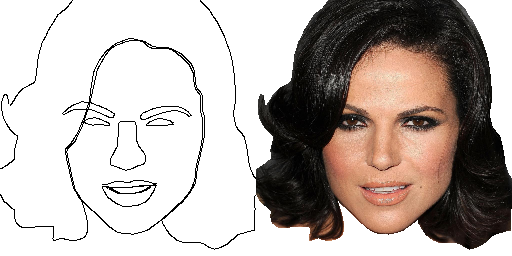

In [ ]:
data_path = "/storage/datasets/gabriela.barreto/edges2faces/edge2face/"
opt = Options(dataroot=data_path, is_train=True)

### **Training part 1**
Following the protocol outlined in the paper, minibatch Stochastic Gradient Descent (SGD) was employed for training, along with the Adam optimizer. The training utilized a learning rate of 0.0002, and the momentum parameters were set at β1 = 0.5 and β2 = 0.999, optimizing the model's convergence and stability during the learning process.
Due to unforeseen infrastructure failures, the training process was abruptly halted. In the following section, training was resumed using the previously saved model weights, ensuring continuity of training without starting over from scratch.







The number of training images = 3193
initialize network with normal
initialize network with normal
model [Pix2PixModel] was created
---------- Networks initialized -------------
DataParallel(
  (module): ResnetGenerator(
    (model): Sequential(
      (0): ReflectionPad2d((3, 3, 3, 3))
      (1): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), bias=False)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU(inplace=True)
      (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): ResnetBlock(
        (conv_block): Sequential(
          (0): ReflectionPad2d((1, 1

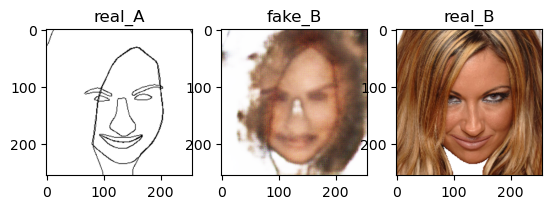

(epoch: 1, iters: 3000, time: 0.384, data: 0.020) G_GAN: 0.889 G_L1: 55.166 D_real: 0.127 D_fake: 0.037 
saving the model at the end of epoch 1, iters 3193
End of epoch 1 / 200 	 Time Taken: 302 sec
learning rate 0.0000200 -> 0.0000200


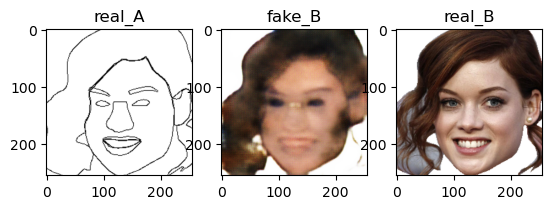

(epoch: 2, iters: 2807, time: 0.363, data: 0.026) G_GAN: 0.910 G_L1: 24.173 D_real: 0.236 D_fake: 0.042 
saving the model at the end of epoch 2, iters 6386
End of epoch 2 / 200 	 Time Taken: 334 sec
learning rate 0.0000200 -> 0.0000200


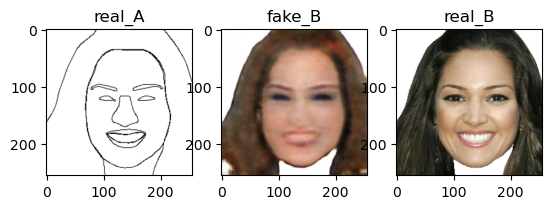

(epoch: 3, iters: 2614, time: 0.361, data: 0.020) G_GAN: 0.761 G_L1: 16.975 D_real: 0.115 D_fake: 0.016 
saving the model at the end of epoch 3, iters 9579
End of epoch 3 / 200 	 Time Taken: 309 sec
learning rate 0.0000200 -> 0.0000200


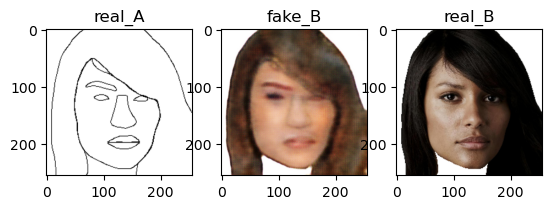

(epoch: 4, iters: 2421, time: 0.363, data: 0.019) G_GAN: 1.072 G_L1: 32.430 D_real: 0.047 D_fake: 0.011 
saving the model at the end of epoch 4, iters 12772
End of epoch 4 / 200 	 Time Taken: 287 sec
learning rate 0.0000200 -> 0.0000200


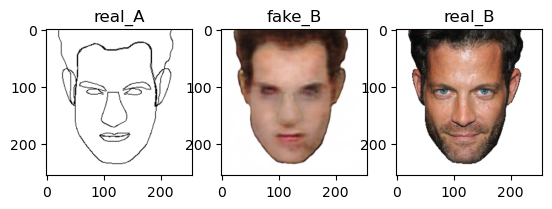

(epoch: 5, iters: 2228, time: 0.363, data: 0.025) G_GAN: 0.810 G_L1: 13.049 D_real: 0.056 D_fake: 0.011 
saving the model at the end of epoch 5, iters 15965
End of epoch 5 / 200 	 Time Taken: 302 sec
learning rate 0.0000200 -> 0.0000200


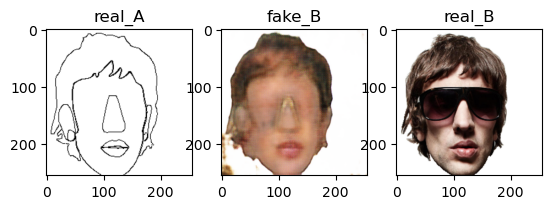

(epoch: 6, iters: 2035, time: 0.918, data: 0.020) G_GAN: 1.093 G_L1: 28.922 D_real: 0.040 D_fake: 0.013 
saving the model at the end of epoch 6, iters 19158
End of epoch 6 / 200 	 Time Taken: 292 sec
learning rate 0.0000200 -> 0.0000200


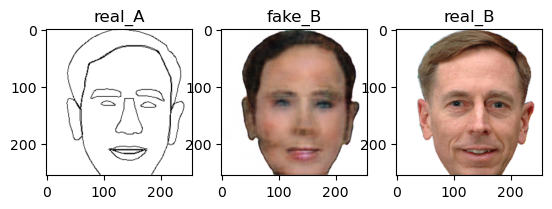

(epoch: 7, iters: 1842, time: 0.384, data: 0.024) G_GAN: 0.792 G_L1: 17.718 D_real: 0.134 D_fake: 0.013 
saving the model at the end of epoch 7, iters 22351
End of epoch 7 / 200 	 Time Taken: 279 sec
learning rate 0.0000200 -> 0.0000200


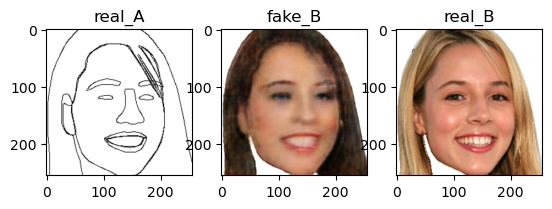

(epoch: 8, iters: 1649, time: 0.367, data: 0.020) G_GAN: 0.997 G_L1: 28.480 D_real: 0.018 D_fake: 0.014 
saving the model at the end of epoch 8, iters 25544
End of epoch 8 / 200 	 Time Taken: 279 sec
learning rate 0.0000200 -> 0.0000200


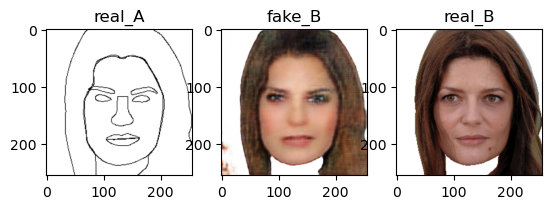

(epoch: 9, iters: 1456, time: 0.364, data: 0.015) G_GAN: 0.803 G_L1: 19.149 D_real: 0.037 D_fake: 0.015 
saving the model at the end of epoch 9, iters 28737
End of epoch 9 / 200 	 Time Taken: 286 sec
learning rate 0.0000200 -> 0.0000200


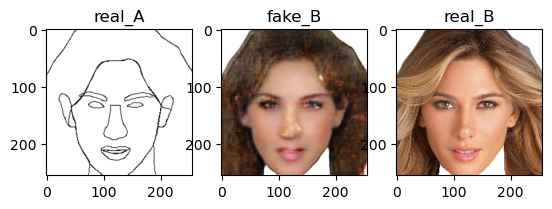

(epoch: 10, iters: 1263, time: 0.372, data: 0.023) G_GAN: 0.823 G_L1: 26.744 D_real: 0.018 D_fake: 0.047 
saving the model at the end of epoch 10, iters 31930
End of epoch 10 / 200 	 Time Taken: 278 sec
learning rate 0.0000200 -> 0.0000200


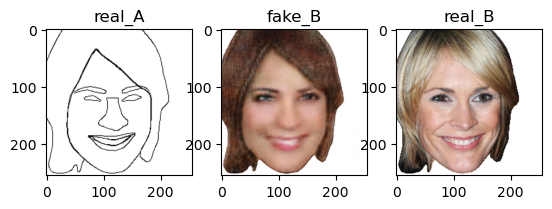

(epoch: 11, iters: 1070, time: 0.374, data: 0.017) G_GAN: 1.039 G_L1: 26.253 D_real: 0.013 D_fake: 0.009 
saving the model at the end of epoch 11, iters 35123
End of epoch 11 / 200 	 Time Taken: 290 sec
learning rate 0.0000200 -> 0.0000200


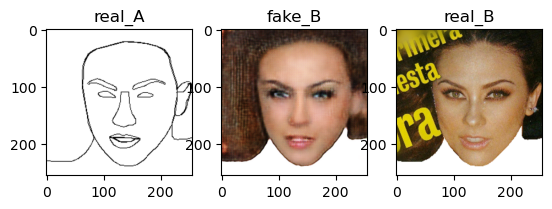

(epoch: 12, iters: 877, time: 0.368, data: 0.018) G_GAN: 1.144 G_L1: 20.746 D_real: 0.015 D_fake: 0.012 
saving the model at the end of epoch 12, iters 38316
End of epoch 12 / 200 	 Time Taken: 343 sec
learning rate 0.0000200 -> 0.0000200


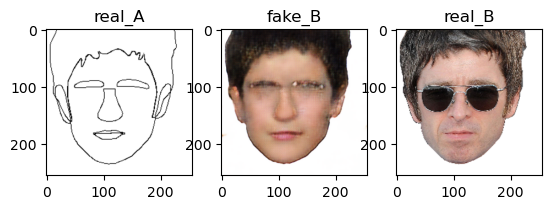

(epoch: 13, iters: 684, time: 0.378, data: 0.017) G_GAN: 1.037 G_L1: 21.350 D_real: 0.007 D_fake: 0.059 
saving the model at the end of epoch 13, iters 41509
End of epoch 13 / 200 	 Time Taken: 344 sec
learning rate 0.0000200 -> 0.0000200


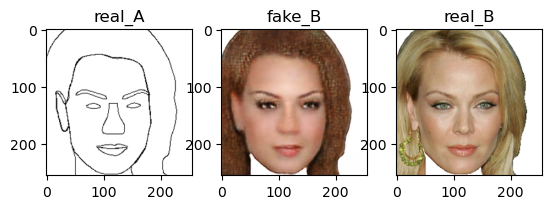

(epoch: 14, iters: 491, time: 0.382, data: 0.019) G_GAN: 0.973 G_L1: 22.039 D_real: 0.009 D_fake: 0.006 
saving the model at the end of epoch 14, iters 44702
End of epoch 14 / 200 	 Time Taken: 322 sec
learning rate 0.0000200 -> 0.0000200


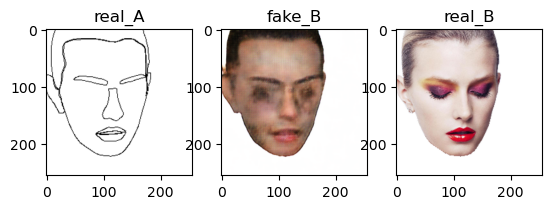

(epoch: 15, iters: 298, time: 0.374, data: 0.025) G_GAN: 0.827 G_L1: 25.499 D_real: 0.037 D_fake: 0.055 
saving the model at the end of epoch 15, iters 47895
End of epoch 15 / 200 	 Time Taken: 393 sec
learning rate 0.0000200 -> 0.0000200


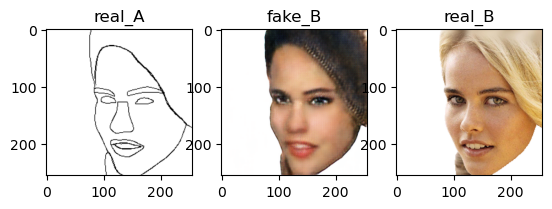

(epoch: 16, iters: 105, time: 0.391, data: 0.023) G_GAN: 0.972 G_L1: 31.450 D_real: 0.014 D_fake: 0.009 


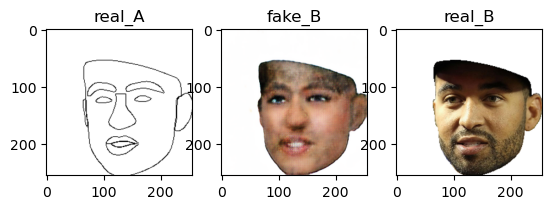

(epoch: 16, iters: 3105, time: 0.358, data: 0.026) G_GAN: 0.908 G_L1: 19.703 D_real: 0.008 D_fake: 0.012 
saving the model at the end of epoch 16, iters 51088
End of epoch 16 / 200 	 Time Taken: 307 sec
learning rate 0.0000200 -> 0.0000200


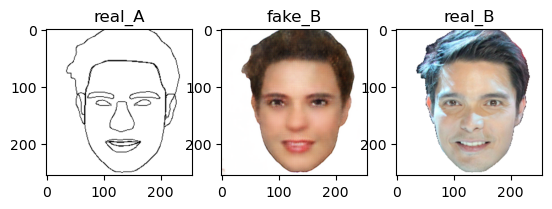

(epoch: 17, iters: 2912, time: 0.374, data: 0.017) G_GAN: 1.006 G_L1: 17.856 D_real: 0.009 D_fake: 0.005 
saving the model at the end of epoch 17, iters 54281
End of epoch 17 / 200 	 Time Taken: 301 sec
learning rate 0.0000200 -> 0.0000200


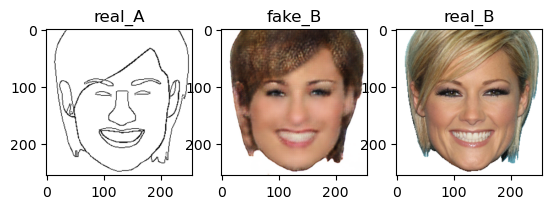

(epoch: 18, iters: 2719, time: 0.380, data: 0.019) G_GAN: 0.948 G_L1: 19.053 D_real: 0.020 D_fake: 0.008 
saving the model at the end of epoch 18, iters 57474
End of epoch 18 / 200 	 Time Taken: 326 sec
learning rate 0.0000200 -> 0.0000200


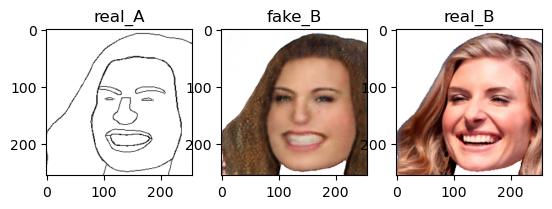

(epoch: 19, iters: 2526, time: 0.381, data: 0.019) G_GAN: 1.086 G_L1: 26.970 D_real: 0.004 D_fake: 0.008 
saving the model at the end of epoch 19, iters 60667
End of epoch 19 / 200 	 Time Taken: 336 sec
learning rate 0.0000200 -> 0.0000200


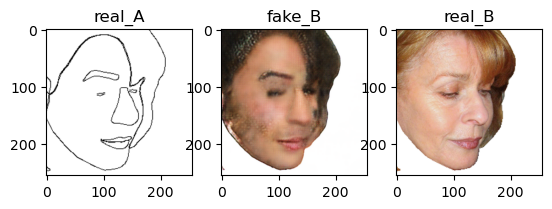

(epoch: 20, iters: 2333, time: 0.374, data: 0.022) G_GAN: 1.053 G_L1: 23.943 D_real: 0.008 D_fake: 0.008 
saving the model at the end of epoch 20, iters 63860
End of epoch 20 / 200 	 Time Taken: 362 sec
learning rate 0.0000200 -> 0.0000200


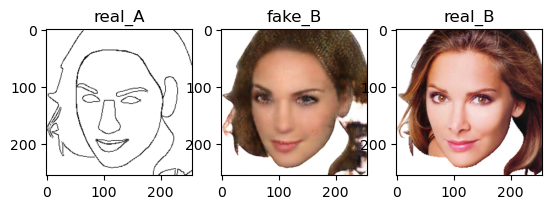

(epoch: 21, iters: 2140, time: 0.377, data: 0.022) G_GAN: 0.873 G_L1: 23.853 D_real: 0.007 D_fake: 0.018 
saving the model at the end of epoch 21, iters 67053
End of epoch 21 / 200 	 Time Taken: 340 sec
learning rate 0.0000200 -> 0.0000200


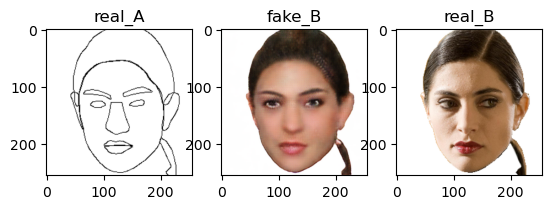

(epoch: 22, iters: 1947, time: 0.359, data: 0.024) G_GAN: 0.943 G_L1: 19.767 D_real: 0.008 D_fake: 0.023 
saving the model at the end of epoch 22, iters 70246
End of epoch 22 / 200 	 Time Taken: 298 sec
learning rate 0.0000200 -> 0.0000200


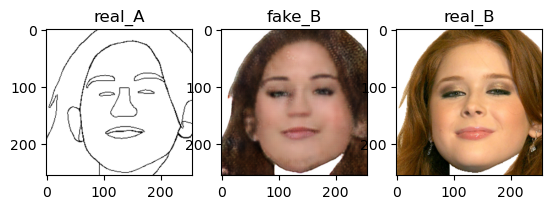

(epoch: 23, iters: 1754, time: 0.394, data: 0.017) G_GAN: 0.993 G_L1: 18.633 D_real: 0.014 D_fake: 0.004 
saving the model at the end of epoch 23, iters 73439
End of epoch 23 / 200 	 Time Taken: 310 sec
learning rate 0.0000200 -> 0.0000200


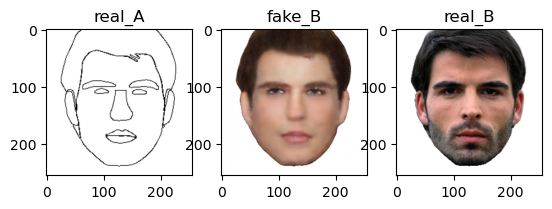

(epoch: 24, iters: 1561, time: 0.378, data: 0.024) G_GAN: 0.993 G_L1: 17.296 D_real: 0.003 D_fake: 0.004 
saving the model at the end of epoch 24, iters 76632
End of epoch 24 / 200 	 Time Taken: 347 sec
learning rate 0.0000200 -> 0.0000200


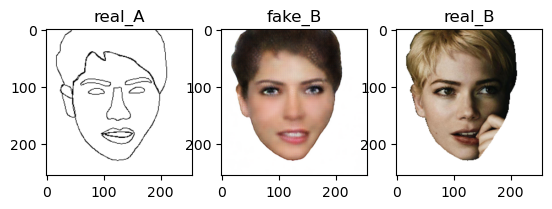

(epoch: 25, iters: 1368, time: 0.358, data: 0.021) G_GAN: 0.991 G_L1: 20.204 D_real: 0.006 D_fake: 0.004 
saving the model at the end of epoch 25, iters 79825
End of epoch 25 / 200 	 Time Taken: 292 sec
learning rate 0.0000200 -> 0.0000200


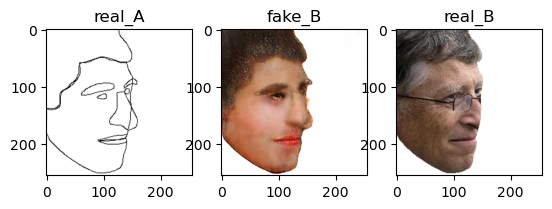

(epoch: 26, iters: 1175, time: 0.358, data: 0.021) G_GAN: 1.124 G_L1: 18.920 D_real: 0.016 D_fake: 0.067 
saving the model at the end of epoch 26, iters 83018
End of epoch 26 / 200 	 Time Taken: 308 sec
learning rate 0.0000200 -> 0.0000200


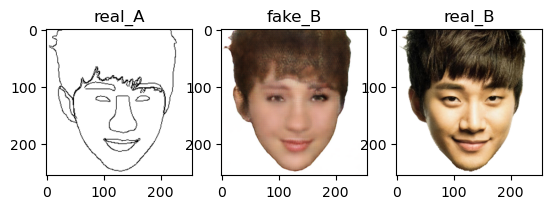

(epoch: 27, iters: 982, time: 0.359, data: 0.018) G_GAN: 1.026 G_L1: 17.018 D_real: 0.003 D_fake: 0.004 
saving the model at the end of epoch 27, iters 86211
End of epoch 27 / 200 	 Time Taken: 285 sec
learning rate 0.0000200 -> 0.0000200


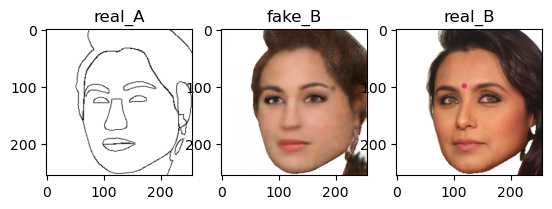

(epoch: 28, iters: 789, time: 0.361, data: 0.026) G_GAN: 1.081 G_L1: 13.211 D_real: 0.004 D_fake: 0.010 
saving the model at the end of epoch 28, iters 89404
End of epoch 28 / 200 	 Time Taken: 311 sec
learning rate 0.0000200 -> 0.0000200


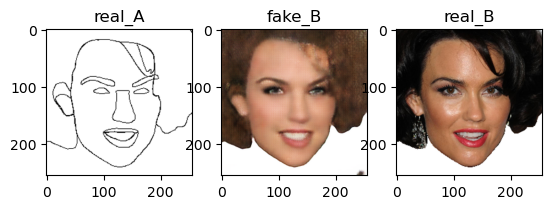

(epoch: 29, iters: 596, time: 0.360, data: 0.016) G_GAN: 1.033 G_L1: 22.147 D_real: 0.003 D_fake: 0.004 
saving the model at the end of epoch 29, iters 92597
End of epoch 29 / 200 	 Time Taken: 304 sec
learning rate 0.0000200 -> 0.0000200


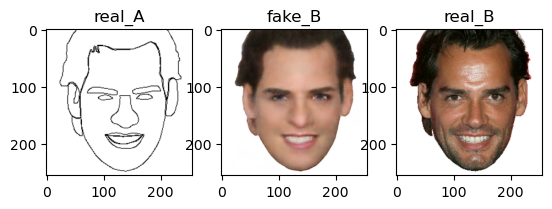

(epoch: 30, iters: 403, time: 0.386, data: 0.018) G_GAN: 0.956 G_L1: 17.319 D_real: 0.006 D_fake: 0.006 
saving the model at the end of epoch 30, iters 95790
End of epoch 30 / 200 	 Time Taken: 308 sec
learning rate 0.0000200 -> 0.0000200


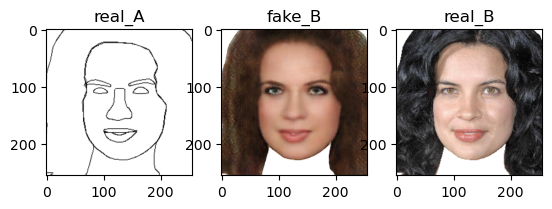

(epoch: 31, iters: 210, time: 0.364, data: 0.023) G_GAN: 1.033 G_L1: 19.779 D_real: 0.004 D_fake: 0.004 
saving the model at the end of epoch 31, iters 98983
End of epoch 31 / 200 	 Time Taken: 317 sec
learning rate 0.0000200 -> 0.0000200


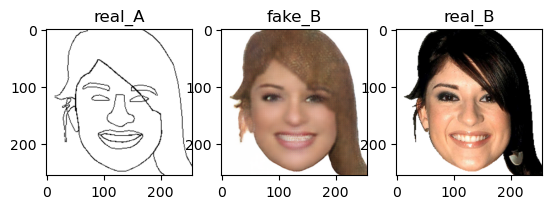

(epoch: 32, iters: 17, time: 0.935, data: 0.016) G_GAN: 0.775 G_L1: 29.303 D_real: 0.020 D_fake: 0.209 


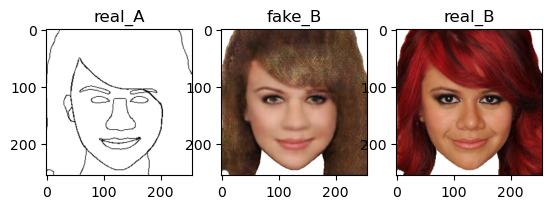

(epoch: 32, iters: 3017, time: 0.402, data: 0.028) G_GAN: 0.768 G_L1: 19.822 D_real: 0.011 D_fake: 0.055 
saving the model at the end of epoch 32, iters 102176
End of epoch 32 / 200 	 Time Taken: 317 sec
learning rate 0.0000200 -> 0.0000200


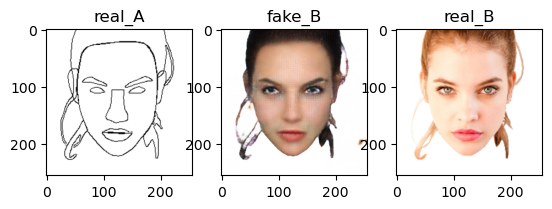

(epoch: 33, iters: 2824, time: 0.359, data: 0.019) G_GAN: 0.851 G_L1: 24.643 D_real: 0.021 D_fake: 0.375 
saving the model at the end of epoch 33, iters 105369
End of epoch 33 / 200 	 Time Taken: 291 sec
learning rate 0.0000200 -> 0.0000200


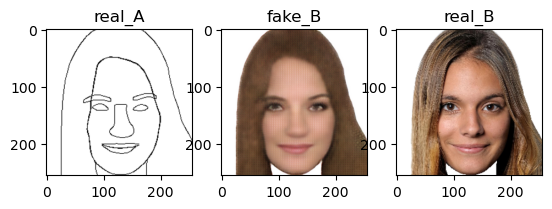

(epoch: 34, iters: 2631, time: 0.381, data: 0.029) G_GAN: 1.015 G_L1: 18.062 D_real: 0.002 D_fake: 0.001 
saving the model at the end of epoch 34, iters 108562
End of epoch 34 / 200 	 Time Taken: 330 sec
learning rate 0.0000200 -> 0.0000200


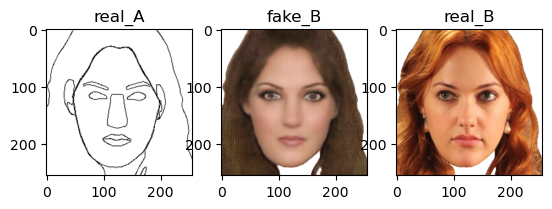

(epoch: 35, iters: 2438, time: 0.367, data: 0.021) G_GAN: 0.958 G_L1: 24.838 D_real: 0.004 D_fake: 0.002 
saving the model at the end of epoch 35, iters 111755
End of epoch 35 / 200 	 Time Taken: 288 sec
learning rate 0.0000200 -> 0.0000200


OSError: [Errno 112] Host is down: '/storage/datasets/gabriela.barreto/edges2faces/edge2face/train/400.png'

In [ ]:
trained_model = train(opt)

### **Training part 2**
Resuming training.

The number of training images = 3193
initialize network with normal
initialize network with normal
model [Pix2PixModel] was created
the name is: G
loading the model from ./checkpoints/35_net_G.pth
the name is: D
loading the model from ./checkpoints/35_net_D.pth
---------- Networks initialized -------------
[Network G] Total number of parameters : 11.377 M
[Network D] Total number of parameters : 2.767 M
-----------------------------------------------
learning rate 0.0000168 -> 0.0000161


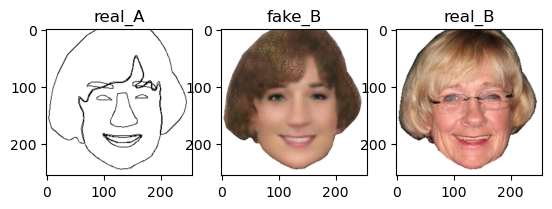

(epoch: 35, iters: 3000, time: 0.386, data: 0.032) G_GAN: 0.979 G_L1: 23.289 D_real: 0.006 D_fake: 0.002 
saving the model at the end of epoch 35, iters 3193
End of epoch 35 / 60 	 Time Taken: 292 sec
learning rate 0.0000161 -> 0.0000155


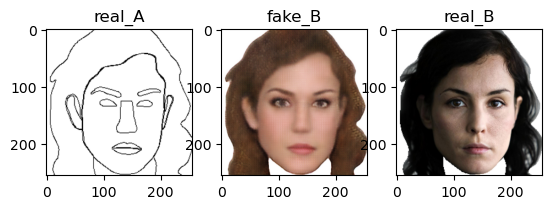

(epoch: 36, iters: 2807, time: 0.382, data: 0.025) G_GAN: 1.060 G_L1: 34.720 D_real: 0.006 D_fake: 0.002 
saving the model at the end of epoch 36, iters 6386
End of epoch 36 / 60 	 Time Taken: 328 sec
learning rate 0.0000155 -> 0.0000148


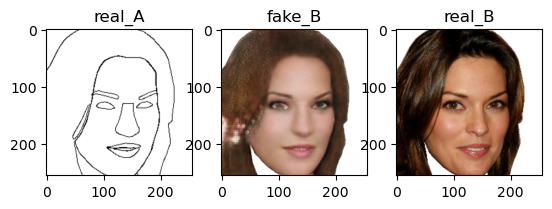

(epoch: 37, iters: 2614, time: 0.366, data: 0.016) G_GAN: 0.849 G_L1: 19.461 D_real: 0.002 D_fake: 0.027 
saving the model at the end of epoch 37, iters 9579
End of epoch 37 / 60 	 Time Taken: 283 sec
learning rate 0.0000148 -> 0.0000142


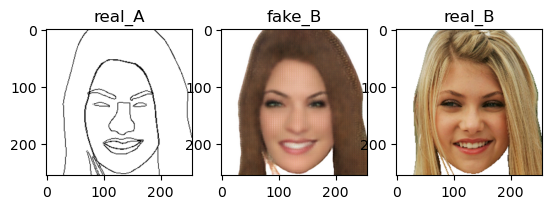

(epoch: 38, iters: 2421, time: 0.362, data: 0.019) G_GAN: 0.983 G_L1: 27.798 D_real: 0.002 D_fake: 0.001 
saving the model at the end of epoch 38, iters 12772
End of epoch 38 / 60 	 Time Taken: 287 sec
learning rate 0.0000142 -> 0.0000135


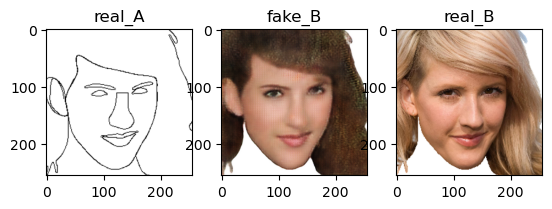

(epoch: 39, iters: 2228, time: 0.382, data: 0.018) G_GAN: 0.951 G_L1: 38.038 D_real: 0.006 D_fake: 0.005 
saving the model at the end of epoch 39, iters 15965
End of epoch 39 / 60 	 Time Taken: 301 sec
learning rate 0.0000135 -> 0.0000129


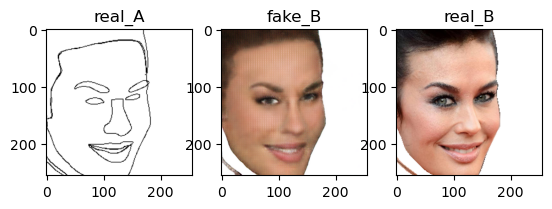

(epoch: 40, iters: 2035, time: 0.360, data: 0.016) G_GAN: 0.947 G_L1: 15.293 D_real: 0.004 D_fake: 0.003 
saving the model at the end of epoch 40, iters 19158
End of epoch 40 / 60 	 Time Taken: 285 sec
learning rate 0.0000129 -> 0.0000123


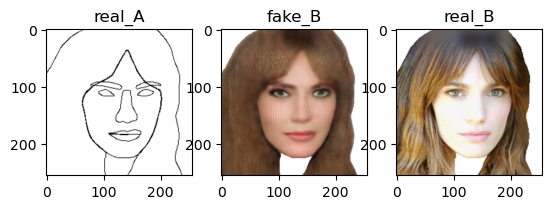

(epoch: 41, iters: 1842, time: 0.366, data: 0.021) G_GAN: 0.975 G_L1: 27.535 D_real: 0.002 D_fake: 0.002 
saving the model at the end of epoch 41, iters 22351
End of epoch 41 / 60 	 Time Taken: 313 sec
learning rate 0.0000123 -> 0.0000116


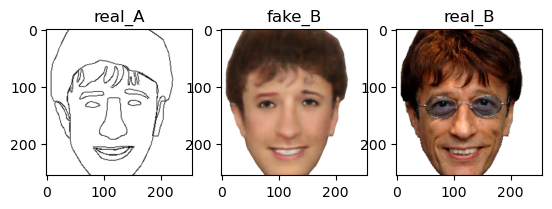

(epoch: 42, iters: 1649, time: 0.362, data: 0.030) G_GAN: 0.990 G_L1: 19.318 D_real: 0.001 D_fake: 0.002 
saving the model at the end of epoch 42, iters 25544
End of epoch 42 / 60 	 Time Taken: 295 sec
learning rate 0.0000116 -> 0.0000110


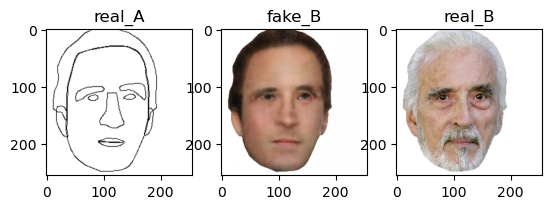

(epoch: 43, iters: 1456, time: 0.359, data: 0.017) G_GAN: 1.105 G_L1: 23.960 D_real: 0.003 D_fake: 0.006 
saving the model at the end of epoch 43, iters 28737
End of epoch 43 / 60 	 Time Taken: 320 sec
learning rate 0.0000110 -> 0.0000103


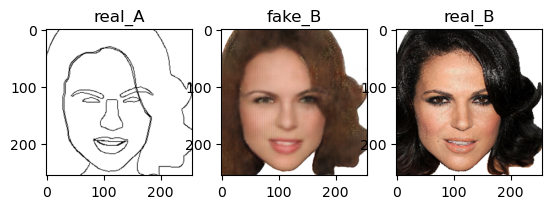

(epoch: 44, iters: 1263, time: 0.369, data: 0.023) G_GAN: 0.974 G_L1: 19.516 D_real: 0.001 D_fake: 0.002 
saving the model at the end of epoch 44, iters 31930
End of epoch 44 / 60 	 Time Taken: 281 sec
learning rate 0.0000103 -> 0.0000097


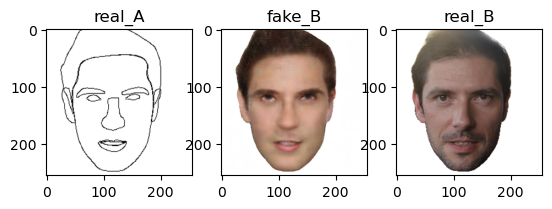

(epoch: 45, iters: 1070, time: 0.395, data: 0.020) G_GAN: 1.028 G_L1: 18.966 D_real: 0.001 D_fake: 0.002 
saving the model at the end of epoch 45, iters 35123
End of epoch 45 / 60 	 Time Taken: 300 sec
learning rate 0.0000097 -> 0.0000090


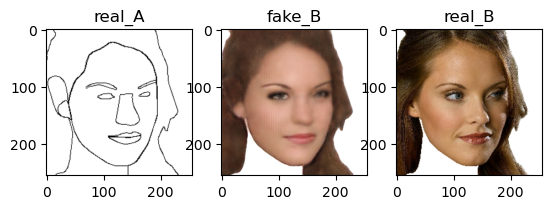

(epoch: 46, iters: 877, time: 0.365, data: 0.021) G_GAN: 1.041 G_L1: 17.389 D_real: 0.008 D_fake: 0.003 
saving the model at the end of epoch 46, iters 38316
End of epoch 46 / 60 	 Time Taken: 291 sec
learning rate 0.0000090 -> 0.0000084


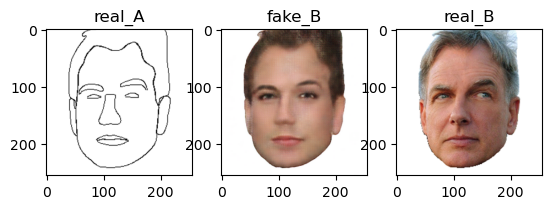

(epoch: 47, iters: 684, time: 0.363, data: 0.019) G_GAN: 0.994 G_L1: 18.497 D_real: 0.010 D_fake: 0.002 
saving the model at the end of epoch 47, iters 41509
End of epoch 47 / 60 	 Time Taken: 298 sec
learning rate 0.0000084 -> 0.0000077


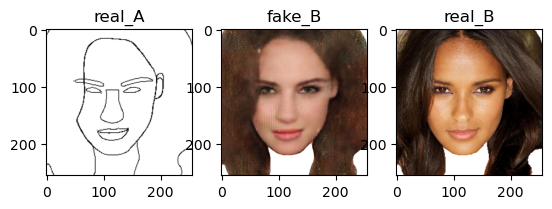

(epoch: 48, iters: 491, time: 0.369, data: 0.015) G_GAN: 1.021 G_L1: 17.575 D_real: 0.004 D_fake: 0.002 
saving the model at the end of epoch 48, iters 44702
End of epoch 48 / 60 	 Time Taken: 301 sec
learning rate 0.0000077 -> 0.0000071


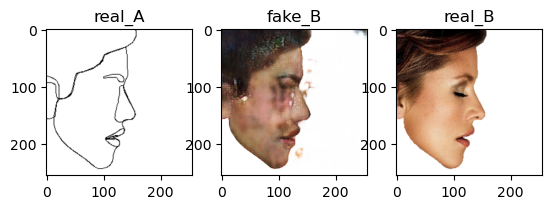

(epoch: 49, iters: 298, time: 0.398, data: 0.018) G_GAN: 0.513 G_L1: 14.397 D_real: 0.002 D_fake: 0.443 
saving the model at the end of epoch 49, iters 47895
End of epoch 49 / 60 	 Time Taken: 316 sec
learning rate 0.0000071 -> 0.0000065


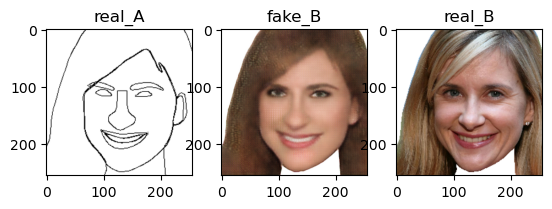

(epoch: 50, iters: 105, time: 0.389, data: 0.019) G_GAN: 1.003 G_L1: 22.442 D_real: 0.001 D_fake: 0.001 


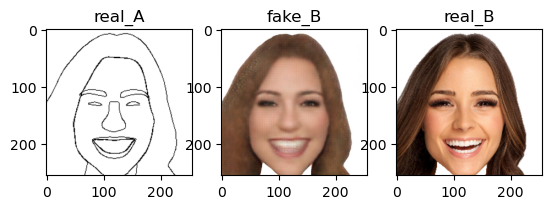

(epoch: 50, iters: 3105, time: 0.380, data: 0.024) G_GAN: 1.009 G_L1: 15.668 D_real: 0.001 D_fake: 0.001 
saving the model at the end of epoch 50, iters 51088
End of epoch 50 / 60 	 Time Taken: 295 sec
learning rate 0.0000065 -> 0.0000058


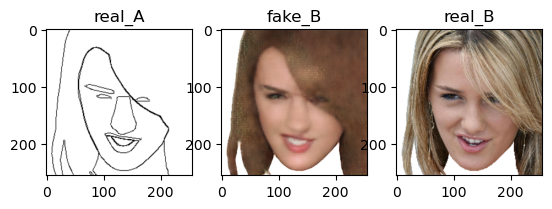

(epoch: 51, iters: 2912, time: 0.385, data: 0.020) G_GAN: 0.968 G_L1: 24.033 D_real: 0.002 D_fake: 0.002 
saving the model at the end of epoch 51, iters 54281
End of epoch 51 / 60 	 Time Taken: 304 sec
learning rate 0.0000058 -> 0.0000052


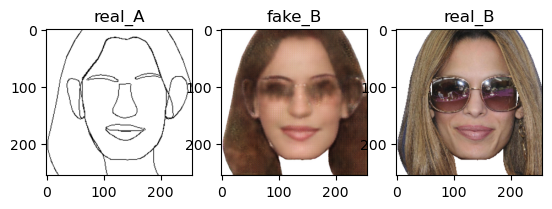

(epoch: 52, iters: 2719, time: 0.384, data: 0.022) G_GAN: 0.994 G_L1: 24.256 D_real: 0.001 D_fake: 0.001 
saving the model at the end of epoch 52, iters 57474
End of epoch 52 / 60 	 Time Taken: 321 sec
learning rate 0.0000052 -> 0.0000045


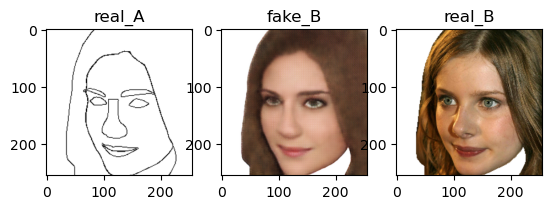

(epoch: 53, iters: 2526, time: 0.393, data: 0.019) G_GAN: 0.977 G_L1: 14.796 D_real: 0.001 D_fake: 0.001 
saving the model at the end of epoch 53, iters 60667
End of epoch 53 / 60 	 Time Taken: 348 sec
learning rate 0.0000045 -> 0.0000039


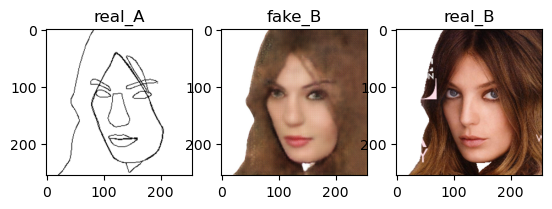

(epoch: 54, iters: 2333, time: 0.364, data: 0.019) G_GAN: 0.960 G_L1: 17.798 D_real: 0.002 D_fake: 0.004 
saving the model at the end of epoch 54, iters 63860
End of epoch 54 / 60 	 Time Taken: 304 sec
learning rate 0.0000039 -> 0.0000032


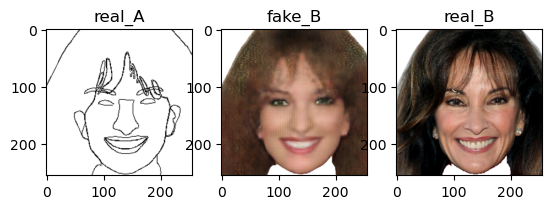

(epoch: 55, iters: 2140, time: 0.375, data: 0.022) G_GAN: 1.000 G_L1: 19.664 D_real: 0.001 D_fake: 0.001 
saving the model at the end of epoch 55, iters 67053
End of epoch 55 / 60 	 Time Taken: 320 sec
learning rate 0.0000032 -> 0.0000026


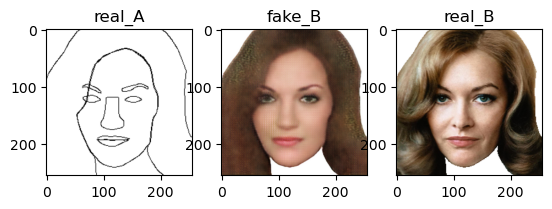

(epoch: 56, iters: 1947, time: 0.367, data: 0.022) G_GAN: 1.002 G_L1: 24.169 D_real: 0.001 D_fake: 0.001 
saving the model at the end of epoch 56, iters 70246
End of epoch 56 / 60 	 Time Taken: 302 sec
learning rate 0.0000026 -> 0.0000019


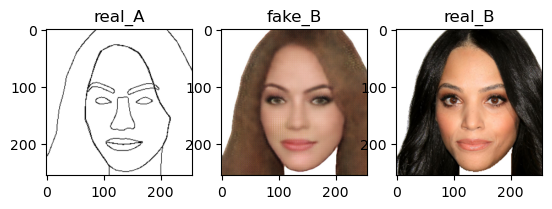

(epoch: 57, iters: 1754, time: 0.395, data: 0.016) G_GAN: 0.968 G_L1: 23.253 D_real: 0.001 D_fake: 0.001 
saving the model at the end of epoch 57, iters 73439
End of epoch 57 / 60 	 Time Taken: 306 sec
learning rate 0.0000019 -> 0.0000013


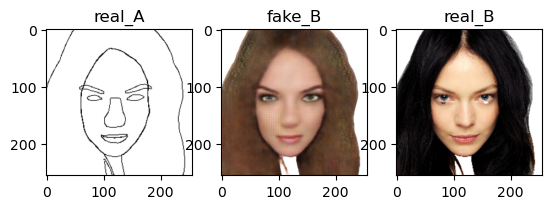

(epoch: 58, iters: 1561, time: 0.363, data: 0.020) G_GAN: 0.968 G_L1: 29.861 D_real: 0.001 D_fake: 0.001 
saving the model at the end of epoch 58, iters 76632
End of epoch 58 / 60 	 Time Taken: 307 sec
learning rate 0.0000013 -> 0.0000006


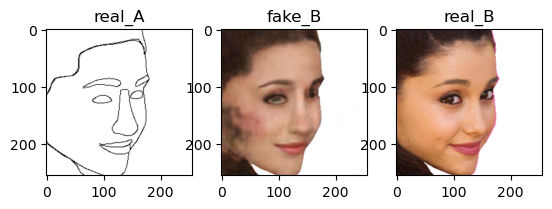

(epoch: 59, iters: 1368, time: 0.361, data: 0.019) G_GAN: 1.016 G_L1: 10.445 D_real: 0.001 D_fake: 0.001 
saving the model at the end of epoch 59, iters 79825
End of epoch 59 / 60 	 Time Taken: 315 sec
learning rate 0.0000006 -> 0.0000000


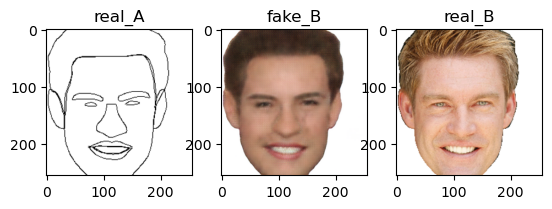

(epoch: 60, iters: 1175, time: 0.384, data: 0.025) G_GAN: 0.979 G_L1: 23.608 D_real: 0.001 D_fake: 0.001 
saving the model at the end of epoch 60, iters 83018
End of epoch 60 / 60 	 Time Taken: 300 sec


In [ ]:
opt = Options(dataroot=data_path, is_train=True, continue_train=True, epoch=35)

trained_model = train(opt)

### **Testing**


Here the model was tested on unforessen data. One can see results achieved are quite good; as stated by the authors “For graphics problems like (...) photo generation, plausibility to a human observer is often the ultimate goal.”  Results found effectively demonstrate the model's capability to handle the data, and to learn conditional distributions they model. Its is impressive how it learned to turn simple edges into good-quality images. The successful application of this model underscores its robustness, proving once again to be a valuable tool in the domain of image-to-image translation. Lastly, it can be noted $L1$ Loss did not encourage average grayish colors in the generated images, which was something to watch out for as it happened in the some of the original experiments described in the paper.

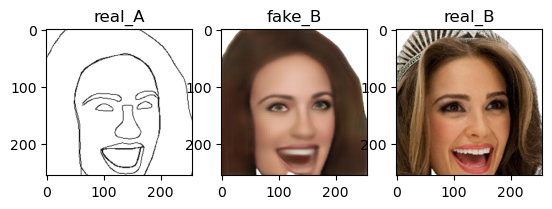

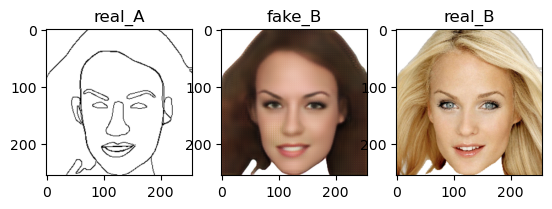

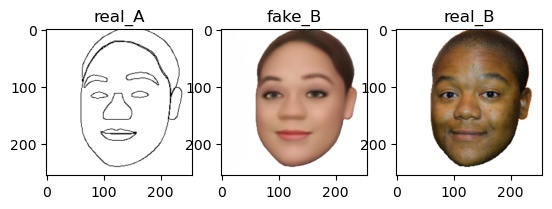

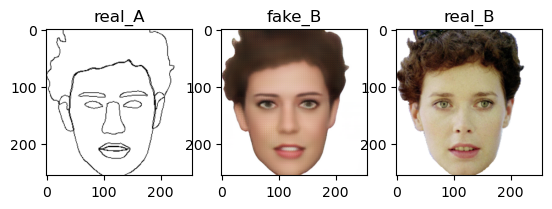

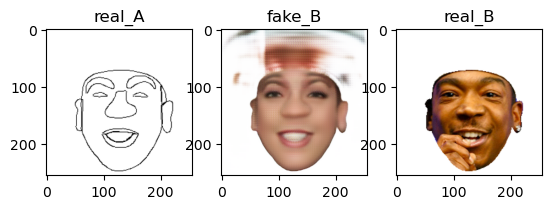

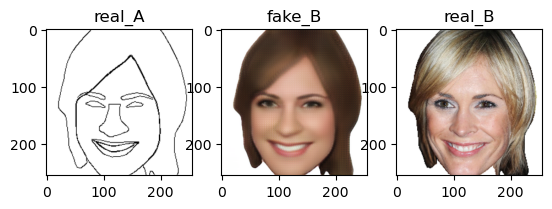

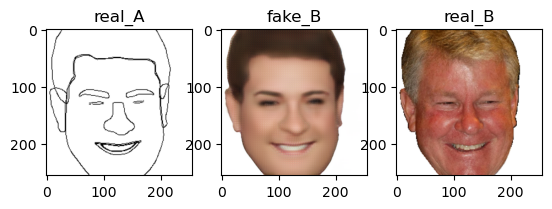

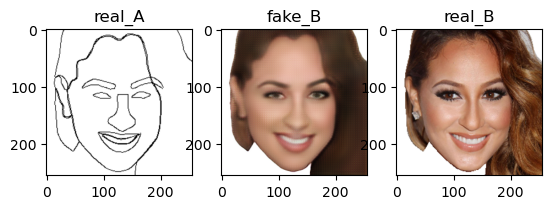

Mean test accuracy = 0.1690898569090492


In [ ]:
test(trained_model)